In [1]:
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from scipy.optimize import root, fixed_point
from numpy import linalg as LA

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Function Definitions

In [17]:
def F(x, r1, r2, r3):
    c1, c2, c3, c4 = 10e-9, 10e-9, 22e-9, 22e-8

    l, lch = 1e-6, 200e-6

    rl, rch = 2., 12.
    Is = 5e-13
    vs = 1.0
    vt = .025
    bf = 100
    br = 10 
    
    ie = Is*((np.exp((x[3]+x[1]-x[2])/vt)-np.exp((x[3]+x[1]-x[0])/vt))+(1/bf)*(np.exp((x[3]+x[1]-x[2])/vt)-1))
    ic = Is*((np.exp((x[3]+x[1]-x[2])/vt)-np.exp((x[3]+x[1]-x[0])/vt))-(1/br)*(np.exp((x[3]+x[1]-x[0])/vt)-1))
    
    x1 = (1/c1)*(x[5]-ic-x[4])
    x2 = (1/c2)*(x[4]+vs/r1-(x[3]+x[1])*(1/r1+1/r2)-ie+ic)
    x3 = (1/c3)*(ie-x[2]/r3)
    x4 = (1/c4)*(vs/r1 - (x[3]+x[1])*(1/r1+1/r2)-ie + ic)
    x5 = (1/l)*(x[0]-x[1]-x[4]*rl)
    x6 = (1/lch)*(vs-x[0]-rch*x[5])
    return [x1, x2, x3, x4, x5, x6]     

In [18]:
def jac ( y, r1, r2, r3) :
    c1, c2, c3, c4 = 10e-9, 10e-9, 22e-9, 22e-8

    l, lch = 1e-6, 200e-6
    
    d = 9900
    rl, rch = 2., 12.
    Is = 5e-13
    vs = 1.0
    vt = .025
    bf = 100
    br = 10
    return np.array([[-1/c1*Is*(np.exp((y[3]+y[1]-y[0])/vt)*(1+1/br)/vt),
                   -1/c1*Is*(np.exp((y[3]+y[1])/vt)*(-np.exp(-y[0]/vt)*(1+1/br)+np.exp(-y[2]/vt))/vt),
                   1/c1*Is*(np.exp((y[3]+y[1]-y[2])/vt)/vt),
                   -1/c1*Is*(np.exp((y[3]+y[1])/vt)*(-np.exp(-y[0]/vt)*(1+1/br)+np.exp(-y[2]/vt))/vt),
                   -1/c1,
                   1/c1],
                  [1/c2*Is*np.exp((y[3]+y[1]-y[0])/vt)/vt/br,
                   1/c2*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                   1/c2*Is*np.exp((y[3]+y[1]-y[2])/vt)/vt/bf,
                   1/c2*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                   1/c2,
                   0],
                  [1/c3*Is*np.exp((y[3]+y[1]-y[0])/vt)/vt,
                   1/c3*Is*(1/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(1+1/bf)-np.exp(-y[0]/vt))),
                   1/c3*(Is*np.exp((y[3]+y[1]-y[2])/vt)/vt*(1+1/bf)-1/r3),
                   1/c3*Is*(1/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(1+1/bf)-np.exp(-y[0]/vt))),
                   0,
                   0],
                  [1/c4*Is*np.exp((y[3]+y[1]-y[0])/vt)/vt/br,
                   1/c4*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                   1/c4*Is*np.exp((y[3]+y[1]-y[2])/vt)/vt/bf,
                   1/c4*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                   0,
                   0],
                  [1/l, -1/l, 0, 0, -rl/l, 0],
                  [-1/lch, 0, 0, 0, 0, -rch/lch]])

In [196]:
def PlotSpectra(param, r1_, r2_, r3_, roots): # param = 0 for R3, 1 for R1/R2
    c1, c2, c3, c4 = 10e-9, 10e-9, 22e-9, 22e-8

    l, lch = 1e-6, 200e-6
    
    rl, rch = 2, 12
    Is = 5e-13
    vs = 1.0
    vt = .025
    bf = 100
    br = 10

    if param == 0:
        N = r3_.size
        A = np.empty(N, dtype=object)
        r1, r2 = r1_, r2_
        for i in range(N):
            y = roots[i]
            r3 = r3_[i]
            A[i] = np.array([[-1/c1*Is*(np.exp((y[3]+y[1]-y[0])/vt)*(1+1/br)/vt),
                           -1/c1*Is*(np.exp((y[3]+y[1])/vt)*(-np.exp(-y[0]/vt)*(1+1/br)+np.exp(-y[2]/vt))/vt),
                           1/c1*Is*(np.exp((y[3]+y[1]-y[2])/vt)/vt),
                           -1/c1*Is*(np.exp((y[3]+y[1])/vt)*(-np.exp(-y[0]/vt)*(1+1/br)+np.exp(-y[2]/vt))/vt),
                           -1/c1,
                           1/c1],
                          [1/c2*Is*np.exp((y[3]+y[1]-y[0])/vt)/vt/br,
                           1/c2*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                           1/c2*Is*np.exp((y[3]+y[1]-y[2])/vt)/vt/bf,
                           1/c2*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                           1/c2,
                           0],
                          [1/c3*Is*np.exp((y[3]+y[1]-y[0])/vt)/vt,
                           1/c3*Is*(1/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(1+1/bf)-np.exp(-y[0]/vt))),
                           1/c3*(Is*np.exp((y[3]+y[1]-y[2])/vt)/vt*(1+1/bf)-1/r3),
                           1/c3*Is*(1/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(1+1/bf)-np.exp(-y[0]/vt))),
                           0,
                           0],
                          [1/c4*Is*np.exp((y[3]+y[1]-y[0])/vt)/vt/br,
                           1/c4*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                           1/c4*Is*np.exp((y[3]+y[1]-y[2])/vt)/vt/bf,
                           1/c4*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                           0,
                           0],
                          [1/l, -1/l, 0, 0, -rl/l, 0],
                          [-1/lch, 0, 0, 0, 0, -rch/lch]])
    if param == 1:
        N = r1_.size
        A = np.empty(N, dtype=object)
        r3 = r3_
        for i in range(N):
            y = roots[i]
            r1, r2 = r1_[i], r2_[i]
            A[i] = np.array([[-1/c1*Is*(np.exp((y[3]+y[1]-y[0])/vt)*(1+1/br)/vt),
                           -1/c1*Is*(np.exp((y[3]+y[1])/vt)*(-np.exp(-y[0]/vt)*(1+1/br)+np.exp(-y[2]/vt))/vt),
                           1/c1*Is*(np.exp((y[3]+y[1]-y[2])/vt)/vt),
                           -1/c1*Is*(np.exp((y[3]+y[1])/vt)*(-np.exp(-y[0]/vt)*(1+1/br)+np.exp(-y[2]/vt))/vt),
                           -1/c1,
                           1/c1],
                          [1/c2*Is*np.exp((y[3]+y[1]-y[0])/vt)/vt/br,
                           1/c2*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                           1/c2*Is*np.exp((y[3]+y[1]-y[2])/vt)/vt/bf,
                           1/c2*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                           1/c2,
                           0],
                          [1/c3*Is*np.exp((y[3]+y[1]-y[0])/vt)/vt,
                           1/c3*Is*(1/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(1+1/bf)-np.exp(-y[0]/vt))),
                           1/c3*(Is*np.exp((y[3]+y[1]-y[2])/vt)/vt*(1+1/bf)-1/r3),
                           1/c3*Is*(1/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(1+1/bf)-np.exp(-y[0]/vt))),
                           0,
                           0],
                          [1/c4*Is*np.exp((y[3]+y[1]-y[0])/vt)/vt/br,
                           1/c4*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                           1/c4*Is*np.exp((y[3]+y[1]-y[2])/vt)/vt/bf,
                           1/c4*(-(1/r1+1/r2)+Is/vt*np.exp((y[3]+y[1])/vt)*(np.exp(-y[2]/vt)*(-1/bf)+np.exp(-y[0]/vt)*(-1/br))),
                           0,
                           0],
                          [1/l, -1/l, 0, 0, -rl/l, 0],
                          [-1/lch, 0, 0, 0, 0, -rch/lch]])

    eigenvalues = np.empty(N, dtype=object)
    eigenvectors = np.empty(N, dtype=object)
    for i in range(N):
        eigenvalues[i], eigenvectors[i] = LA.eig(A[i])  

    w0 = np.sqrt((c1+c2)/(l*c1*c2))
    w0
    w1 = np.zeros(N)
    w2 = np.zeros(N)
    w3 = np.zeros(N)
    w4 = np.zeros(N)
    w5 = np.zeros(N)
    w6 = np.zeros(N)
    
    for i in range(N):
        w1[i] = eigenvalues[i][0].imag
        w2[i] = eigenvalues[i][1].imag
        w3[i] = eigenvalues[i][2].imag
        w4[i] = eigenvalues[i][3].imag
        w5[i] = eigenvalues[i][4].imag
        w6[i] = eigenvalues[i][5].imag
    
    s1 = np.zeros(N)
    s2 = np.zeros(N)
    s3 = np.zeros(N)
    s4 = np.zeros(N)
    s5 = np.zeros(N)
    s6 = np.zeros(N)
    
    for i in range(N):
        s1[i] = eigenvalues[i][0].real
        s2[i] = eigenvalues[i][1].real
        s3[i] = eigenvalues[i][2].real
        s4[i] = eigenvalues[i][3].real
        s5[i] = eigenvalues[i][4].real
        s6[i] = eigenvalues[i][5].real

    if param == 0:
        fig = plt.figure(figsize=(15,15), dpi=300)
        ax0 = fig.add_subplot(2, 1, 1, xlabel='$R_3$', ylabel='$\omega/\omega_0$', title='')
        ax0.grid()
        ax0.plot(r3_, w1/w0, '.', label='c1')
        ax0.plot(r3_, w2/w0, '.', label='c2')
        ax0.plot(r3_, w3/w0, '.', label='c3')
        ax0.plot(r3_, w4/w0, '.', label='c4')
        #ax0.plot(r3_, w5/w0, '.', label='l')
        #ax0.plot(r3_, w6/w0, '.', label='l_{ch}')
        ax0.legend()
        
        ax1 = fig.add_subplot(2, 1, 2, xlabel='$R_3$', ylabel='$\sigma/\omega_0$', title='', ylim=(-.2,.2))
        ax1.grid()
        ax1.plot(r3_, s1/w0, '*', label='c1')
        ax1.plot(r3_, s2/w0, '.', label='c2')
        ax1.plot(r3_, s3/w0, '*', label='c3')
        ax1.plot(r3_, s4/w0, '.', label='c4')
        #ax1.plot(r3_, s5/w0, '.', label='l')
        #ax1.plot(r3_, s6/w0, '.', label='l_{ch}')
        ax1.legend()

    if param == 1:
        fig = plt.figure(figsize=(15,15), dpi=300, layout='constrained')
        ax0 = fig.add_subplot(3, 1, 1, xlabel='$R_1/R_2$', ylabel='$\omega/\omega_0$', title='')
        ax0.grid()
        ax0.semilogx(r1_/r2_, w1/w0, '.', label='c1')
        ax0.semilogx(r1_/r2_, w2/w0, '.', label='c2')
        ax0.semilogx(r1_/r2_, w3/w0, '*', label='c3')
        ax0.semilogx(r1_/r2_, w4/w0, '.', label='c4')
        #ax0.semilogx(r1_/r2_, w5/w0, '*', label='l')
        #ax0.semilogx(r1_/r2_, w6/w0, '.', label='l{ch}')
        ax0.legend()
        
        ax1 = fig.add_subplot(3, 1, 2, xlabel='$R_1/R_2$', ylabel='$\sigma/\omega_0$', title='', ylim=(-.8,.8))
        ax1.grid()
        ax1.semilogx(r1_/r2_, s1/w0, '*', label='c1')
        ax1.semilogx(r1_/r2_, s2/w0, '.', label='c2')
        ax1.semilogx(r1_/r2_, s3/w0, '*', label='c3')
        ax1.semilogx(r1_/r2_, s4/w0, '.', label='c4')
        #ax1.semilogx(r1_/r2_, s5/w0, '*', label='l')
        #ax1.semilogx(r1_/r2_, s6/w0, '.', label='l_{ch}')
        ax1.legend()
        
        ax2 = fig.add_subplot(3, 1, 3, xlabel='$R_1/R_2$', ylabel='$\sigma/\omega_0$', title='', ylim=(-.1,.1), xlim=(0.1,1))
        ax2.grid()
        ax2.semilogx(r1_/r2_, (s1+s2+s3+s4+s5+s6)/6/w0, label='\Sigma \sigma/(n\omega_0)')
    
    return

<>:119: SyntaxWarning: invalid escape sequence '\o'
<>:129: SyntaxWarning: invalid escape sequence '\s'
<>:141: SyntaxWarning: invalid escape sequence '\o'
<>:151: SyntaxWarning: invalid escape sequence '\s'
<>:161: SyntaxWarning: invalid escape sequence '\s'
<>:163: SyntaxWarning: invalid escape sequence '\S'
<>:119: SyntaxWarning: invalid escape sequence '\o'
<>:129: SyntaxWarning: invalid escape sequence '\s'
<>:141: SyntaxWarning: invalid escape sequence '\o'
<>:151: SyntaxWarning: invalid escape sequence '\s'
<>:161: SyntaxWarning: invalid escape sequence '\s'
<>:163: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipykernel_89439/105954120.py:119: SyntaxWarning: invalid escape sequence '\o'
  ax0 = fig.add_subplot(2, 1, 1, xlabel='$R_3$', ylabel='$\omega/\omega_0$', title='')
/tmp/ipykernel_89439/105954120.py:129: SyntaxWarning: invalid escape sequence '\s'
  ax1 = fig.add_subplot(2, 1, 2, xlabel='$R_3$', ylabel='$\sigma/\omega_0$', title='', ylim=(-.2,.2))
/tmp/ipykernel_89439/

# 1V

## Initial values

In [150]:
N = 10000
d = 4500.0
r1_0, r2_0 = d, 1e4-d

x0 = [0.9891710854586997,
      0.9888673868726662,
      0.4105287326220948,
      -0.0502639525831824,
      0.00015127253751564393,
      0.0008838216775773175]

r3_0 = 515.0

## R3, r1=4500

In [151]:
root_forward = np.empty((N,6))
r3_forward = np.linspace(r3_0, 2000, N)

In [152]:
root_forward[0] = root(F, x0, args=(r1_0, r2_0, r3_0), jac=jac, method='hybr', options={"xtol":0.000001, "eps":0.00001}).x

for i in range(N-1):
    root_forward[i+1] = root(F, root_forward[i], args=(r1_0, r2_0, r3_forward[i+1]), jac=jac).x

\
\
These plots showing the time derivative of state variables against the parameterized value are illustrating the fixed point that the limit cycle settles into after some time $T$


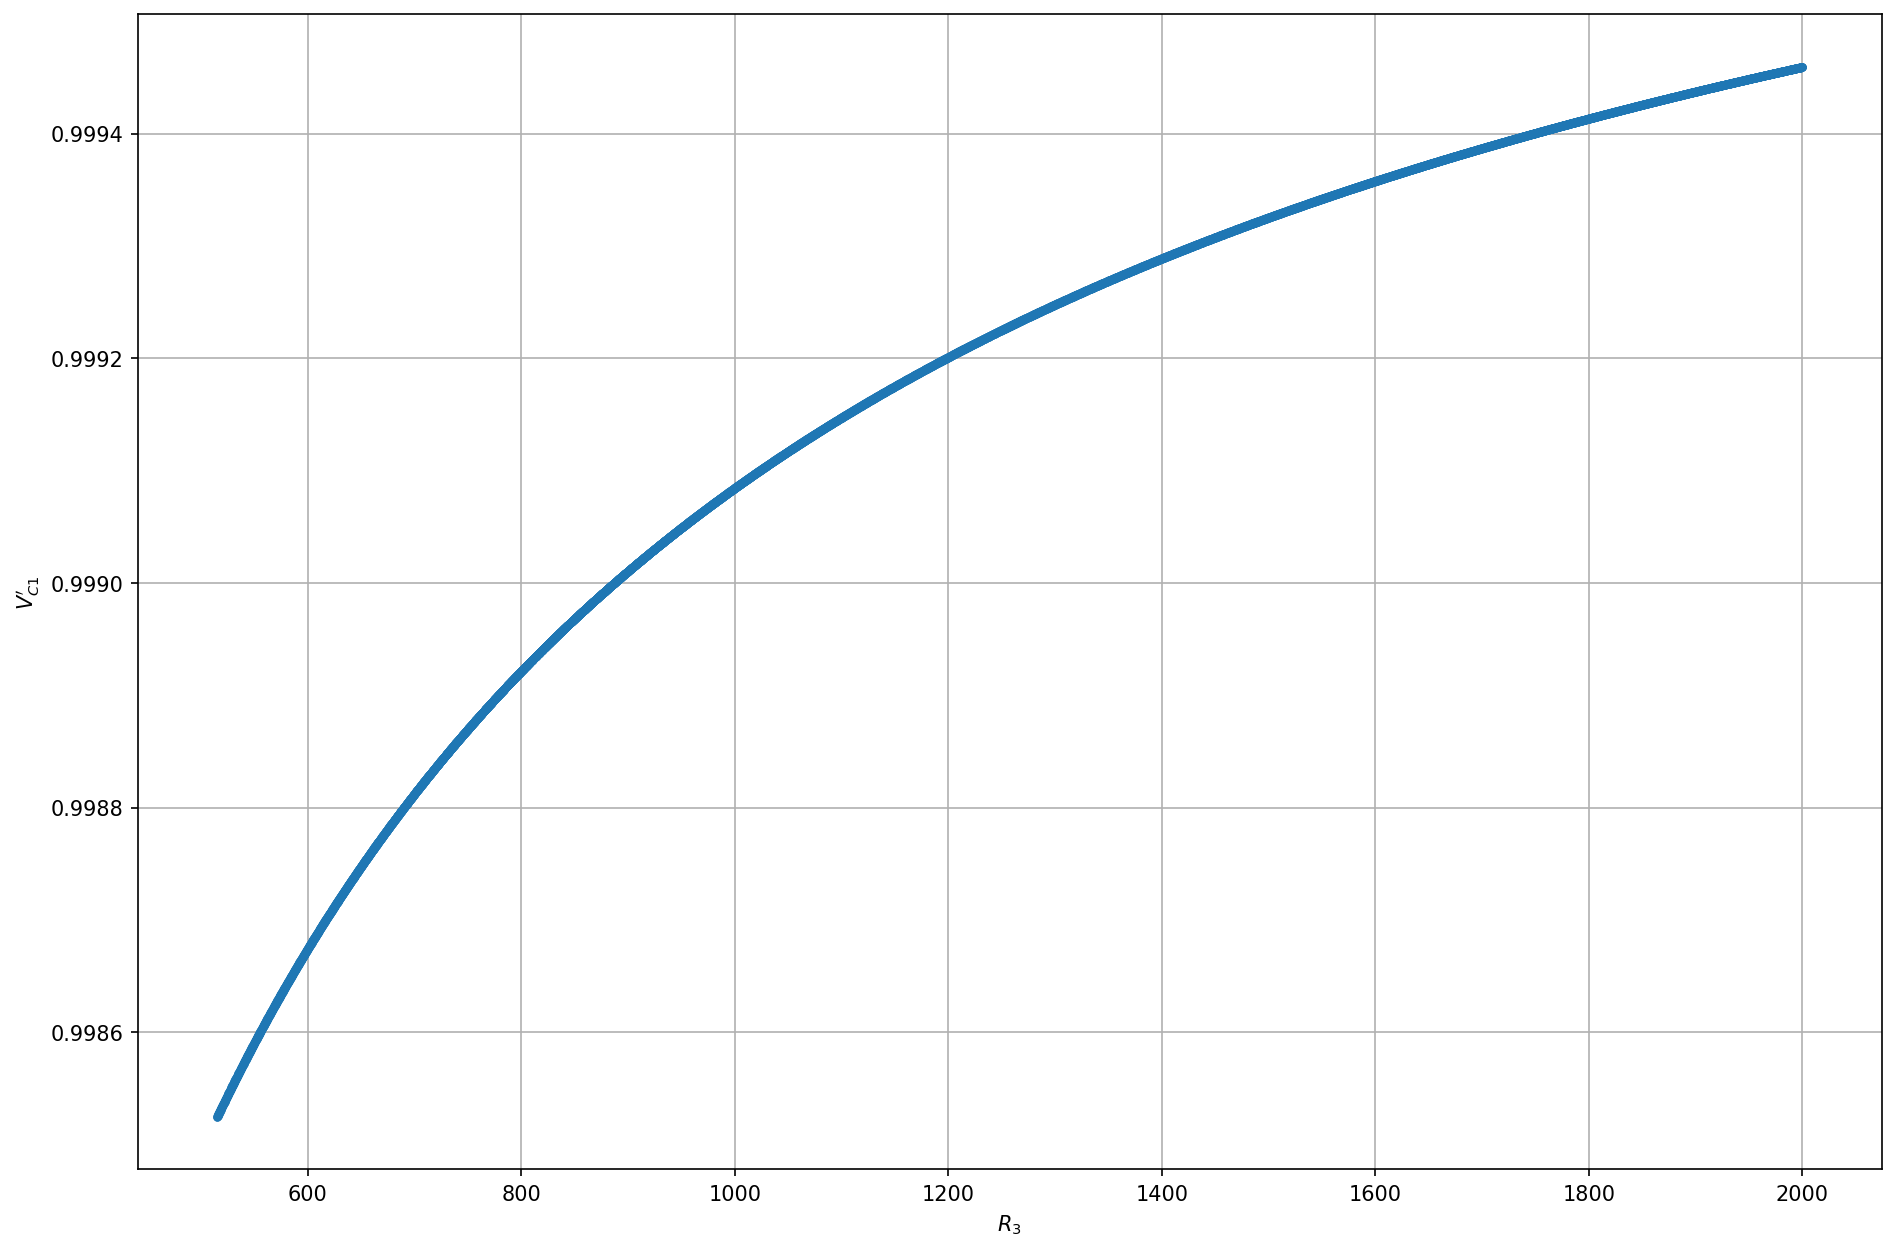

In [153]:
fig = plt.figure(figsize=(15,10), dpi=150)
ax0 = fig.add_subplot(1, 1, 1, xlabel='$R_3$', ylabel='$V_{C1}\'$', title='')
ax0.grid()
ax0.plot(r3_forward[0:], root_forward[:,0], '.')

In [154]:
root_backward = np.empty((N,6))
r3_backward = np.linspace(2, r3_0, N)

In [155]:
root_backward[-1] = root(F, x0, args=(r1_0, r2_0, r3_0), jac=jac).x
root_backward[-1]
for i in range(N-1):
    root_backward[-(i+2)] = root(F, root_backward[-(i+1)], args=(r1_0, r2_0, r3_backward[-(i+2)]), jac=jac).x

array([ 9.98524702e-01,  9.98524702e-01,  6.39480333e-02, -4.51567504e-01,
        1.33302381e-20,  1.22941524e-04])

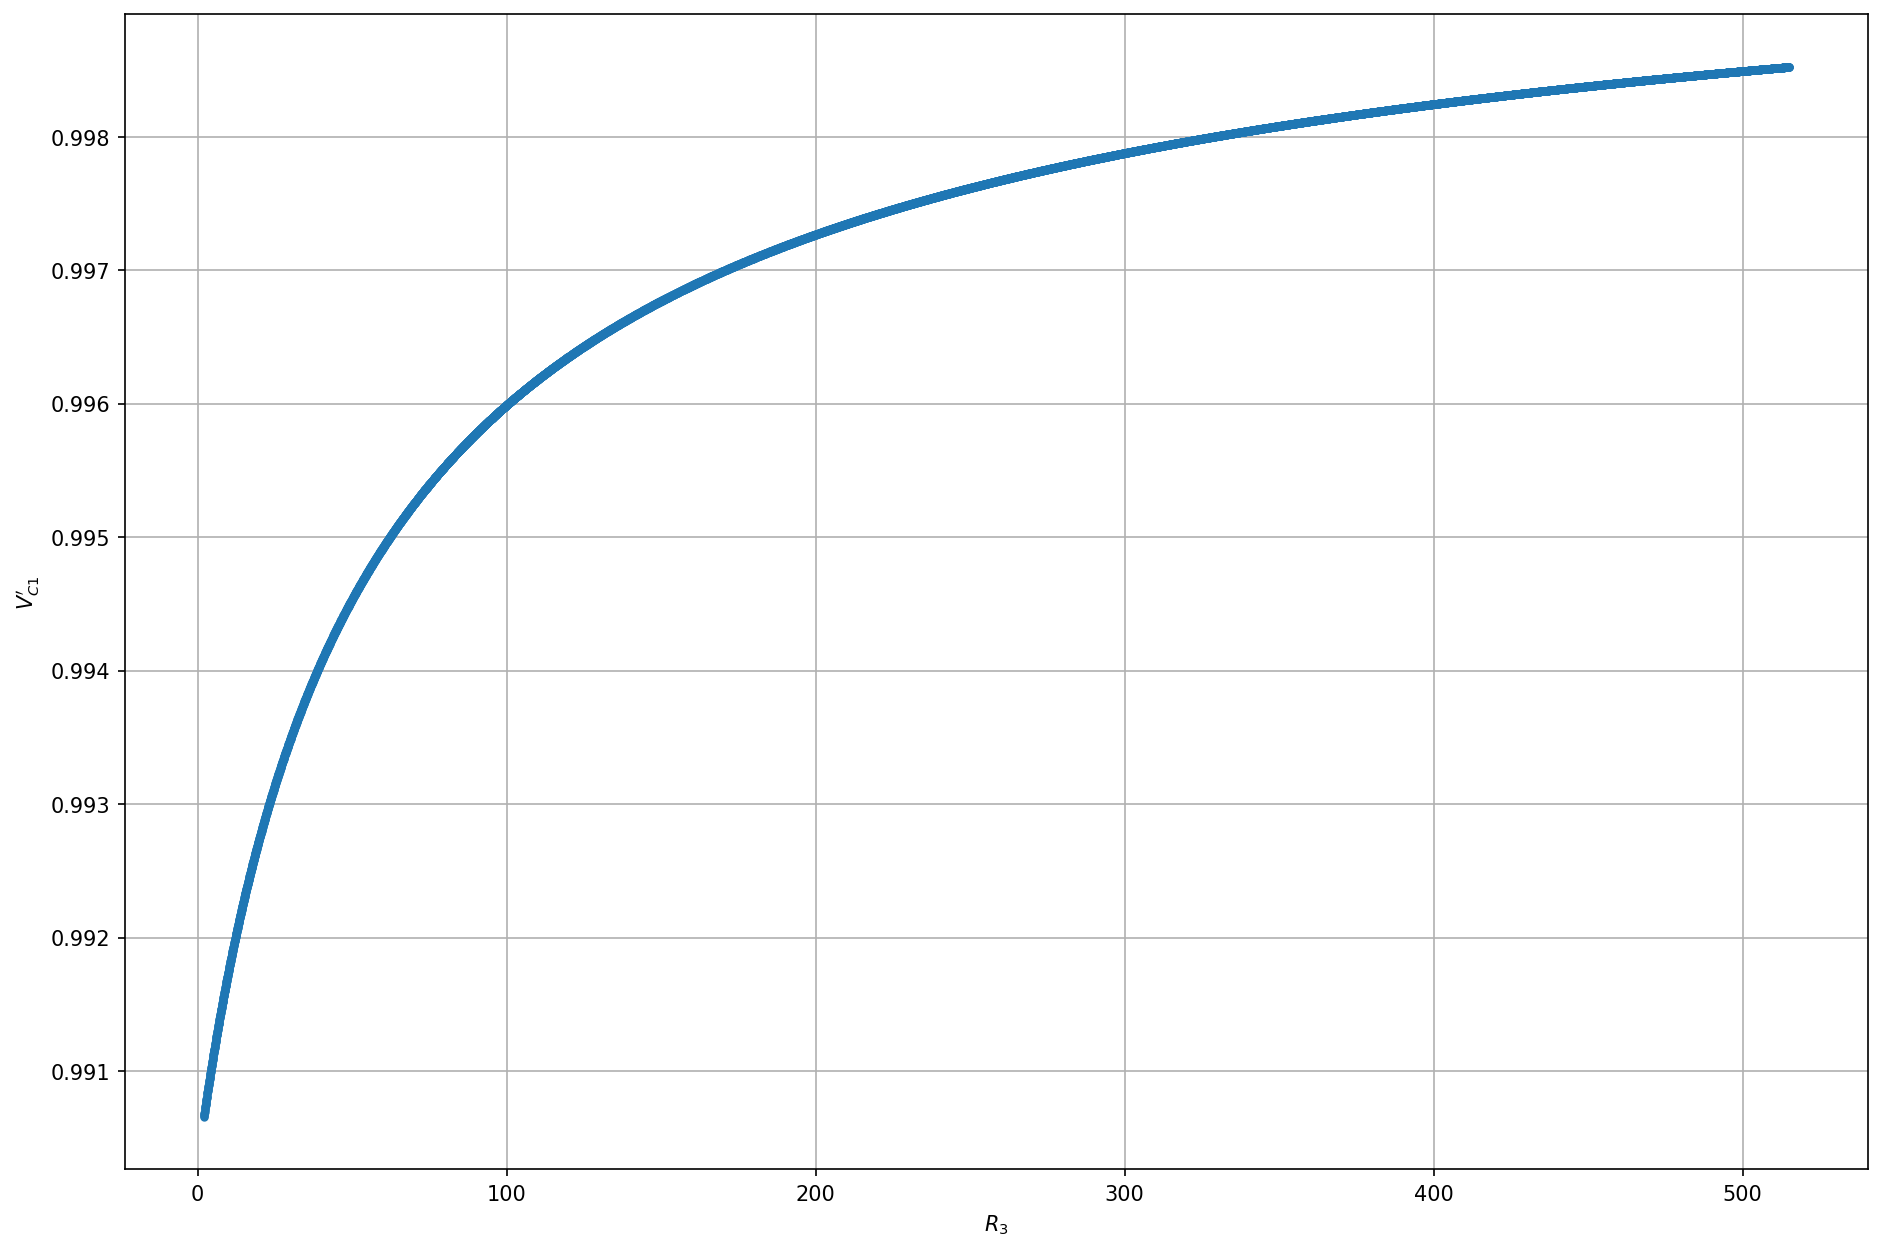

In [156]:
fig = plt.figure(figsize=(15,10), dpi=150)
ax0 = fig.add_subplot(1, 1, 1, xlabel='$R_3$', ylabel='$V_{C1}\'$', title='')
ax0.grid()
ax0.plot(r3_backward[0:], root_backward[:,0], '.')

In [157]:
r3_, roots = np.append(r3_backward, r3_forward), np.append(root_backward, root_forward, axis=0)

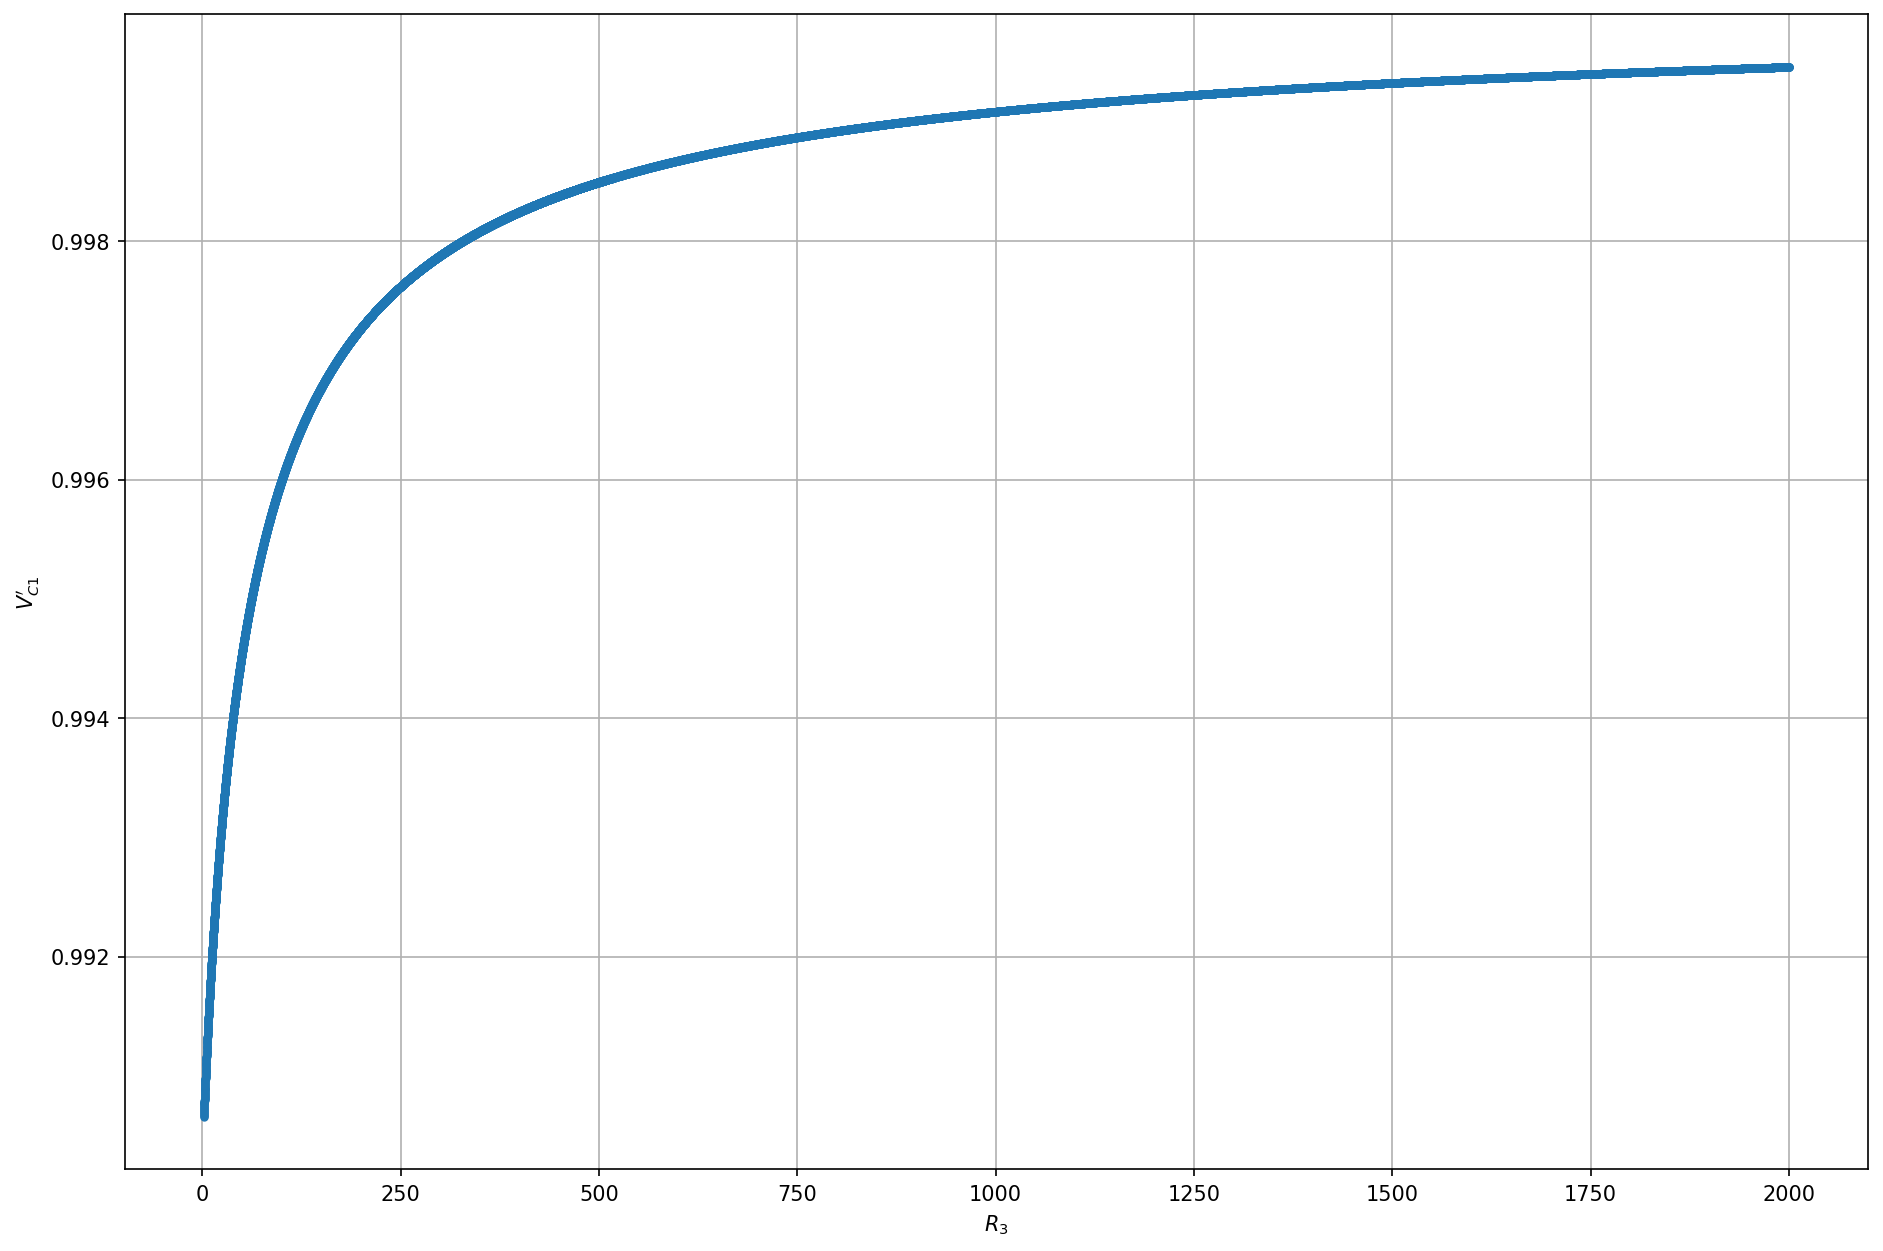

In [158]:
fig = plt.figure(figsize=(15,10), dpi=150)
ax0 = fig.add_subplot(1, 1, 1, xlabel='$R_3$', ylabel='$V_{C1}\'$', title='')
ax0.grid()
ax0.plot(r3_, roots[:,1], '.')

\
\
These multicolored graphs show the real and imaginary components of the eigen values of the linearized system about the fixed points against the parameterized value. Top is the real graph is the real component and the bottom is the imaginary component.

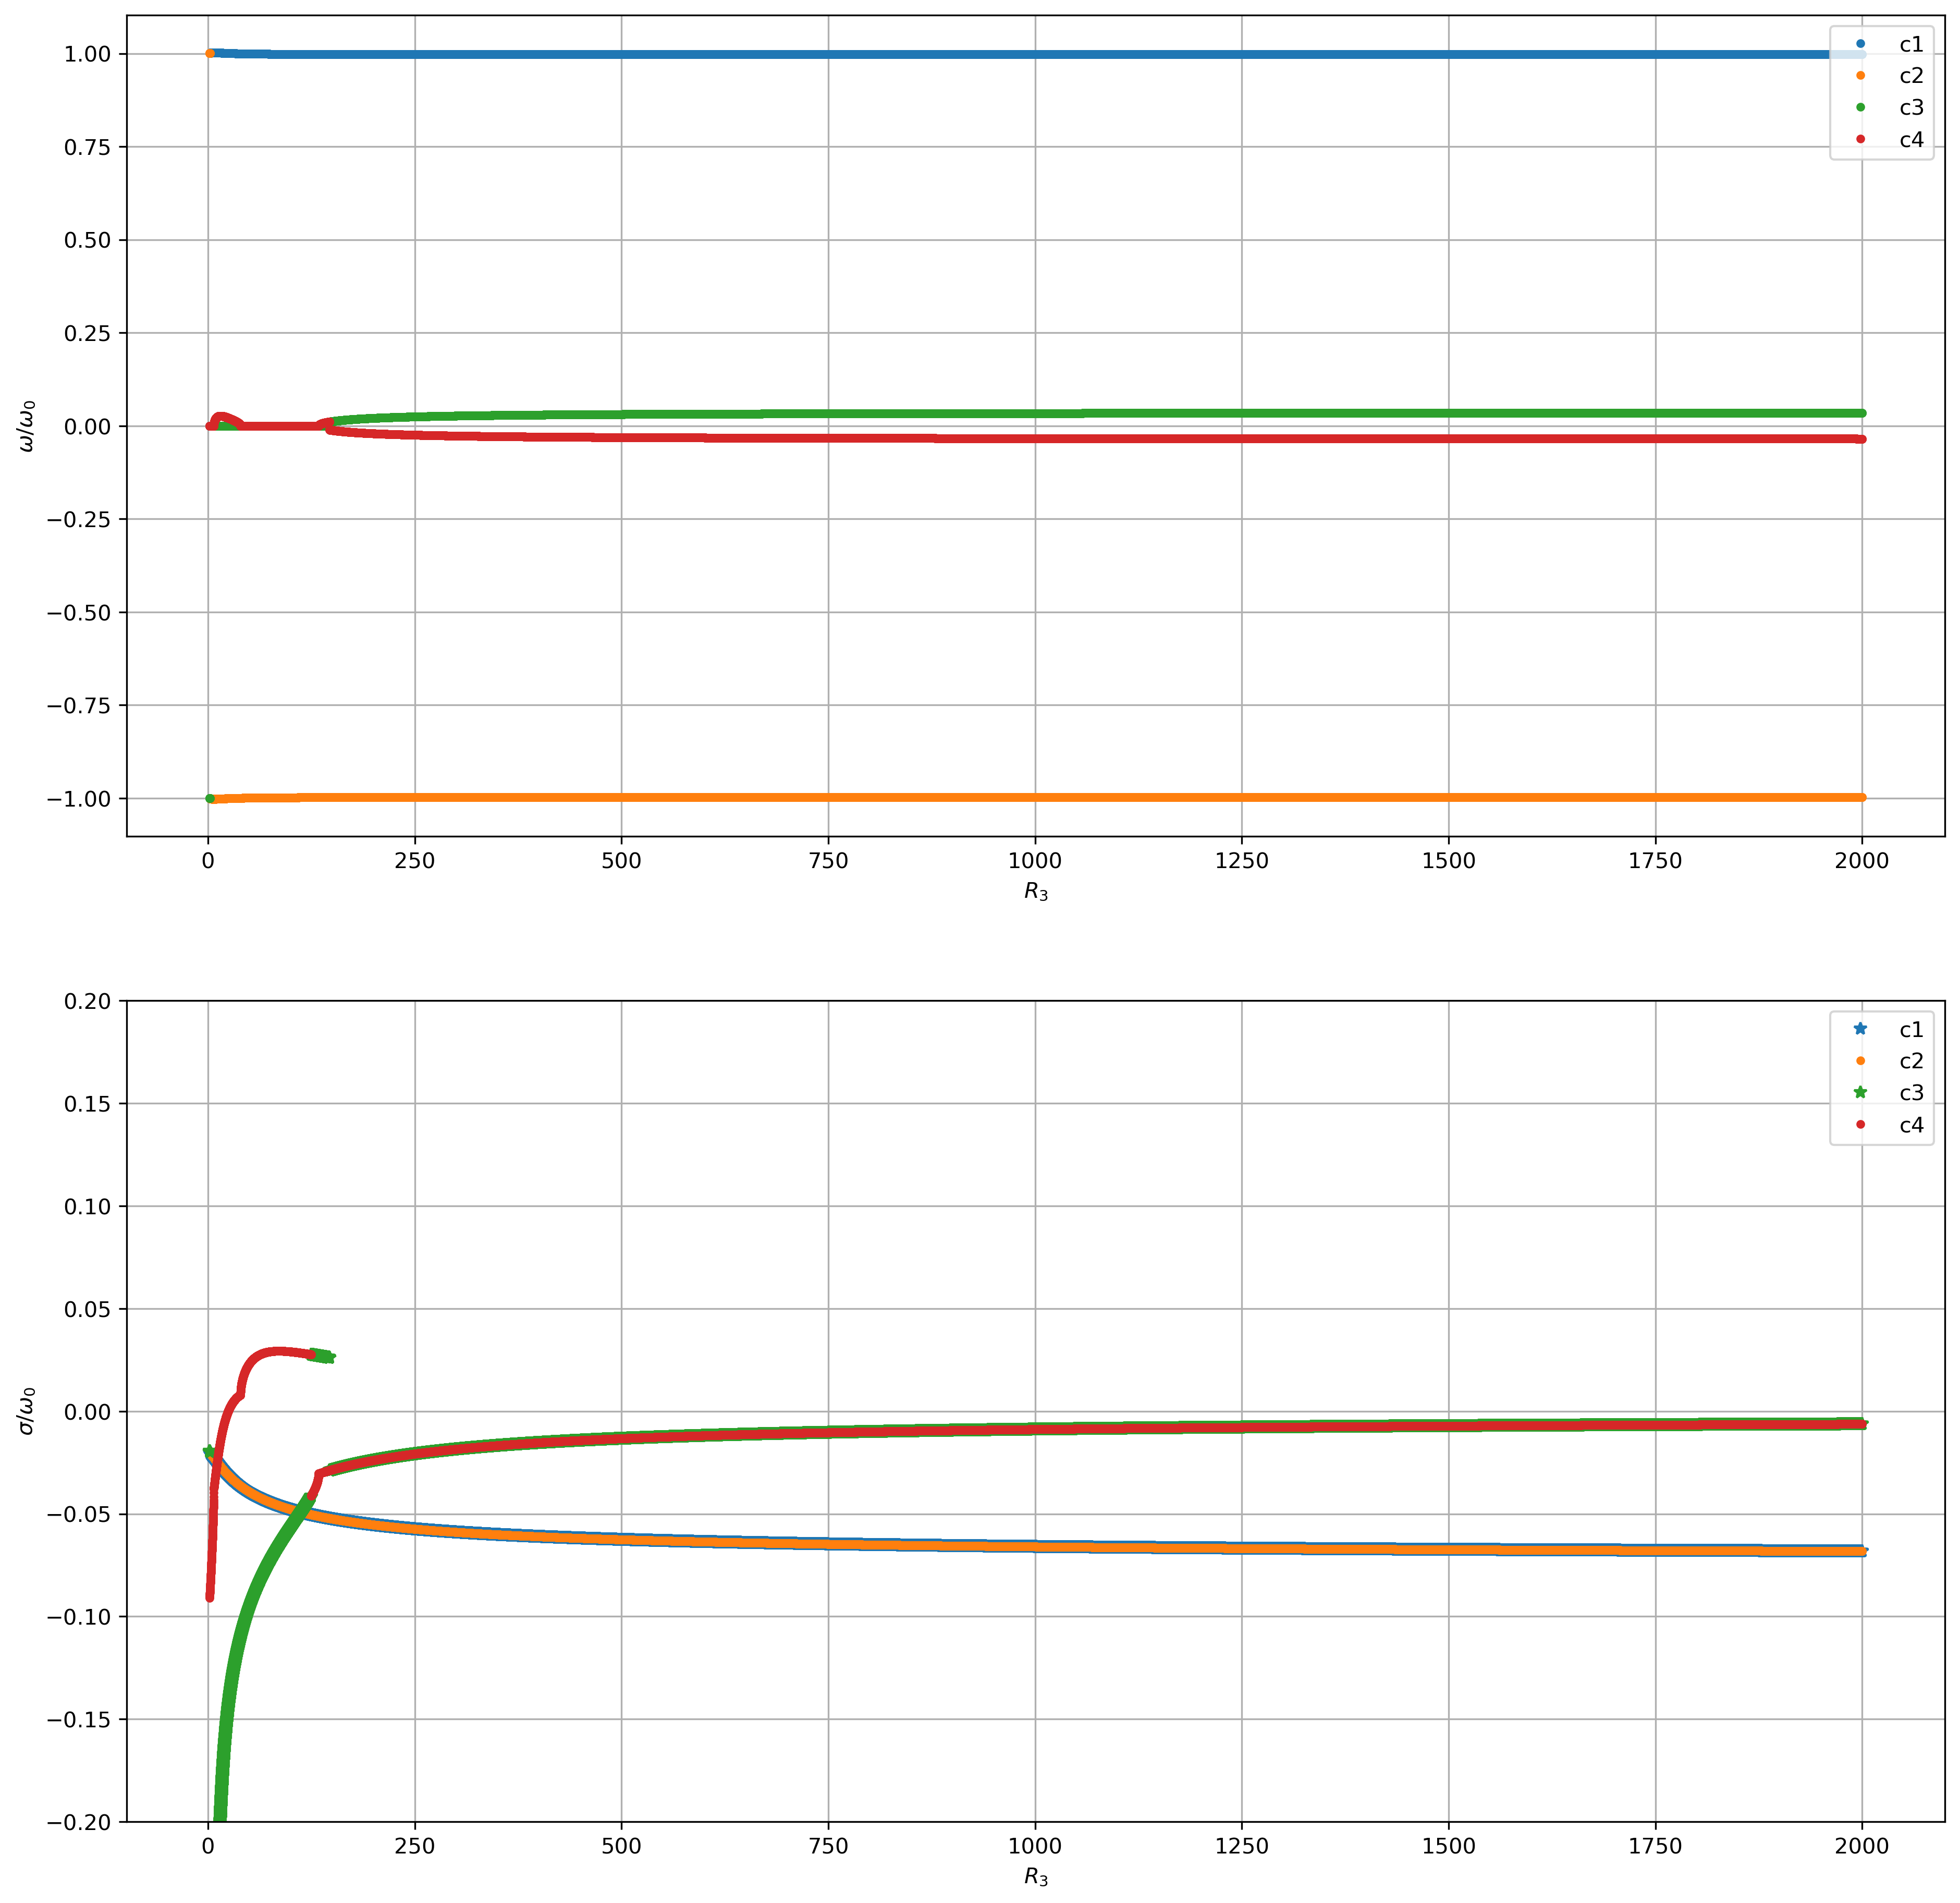

In [159]:
PlotSpectra(0, 4500, 5500, r3_, roots)

## R1/R2, r3=515

In [160]:
root_forward_r1r2 = np.empty((N,6))
r1_forward = np.linspace(r1_0, 9999, N)

In [161]:
root_forward_r1r2[0] = root(F, x0, args=(r1_0, r2_0, r3_0), jac=jac, method='hybr', options={"xtol":0.000001, "factor":10}).x

for i in range(N-1):
    root_forward_r1r2[i+1] = root(F, root_forward_r1r2[i], args=(r1_forward[i+1], 10000 - r1_forward[i+1], r3_0), jac=jac, method='hybr', options={"xtol":0.000001, "factor":1}).x

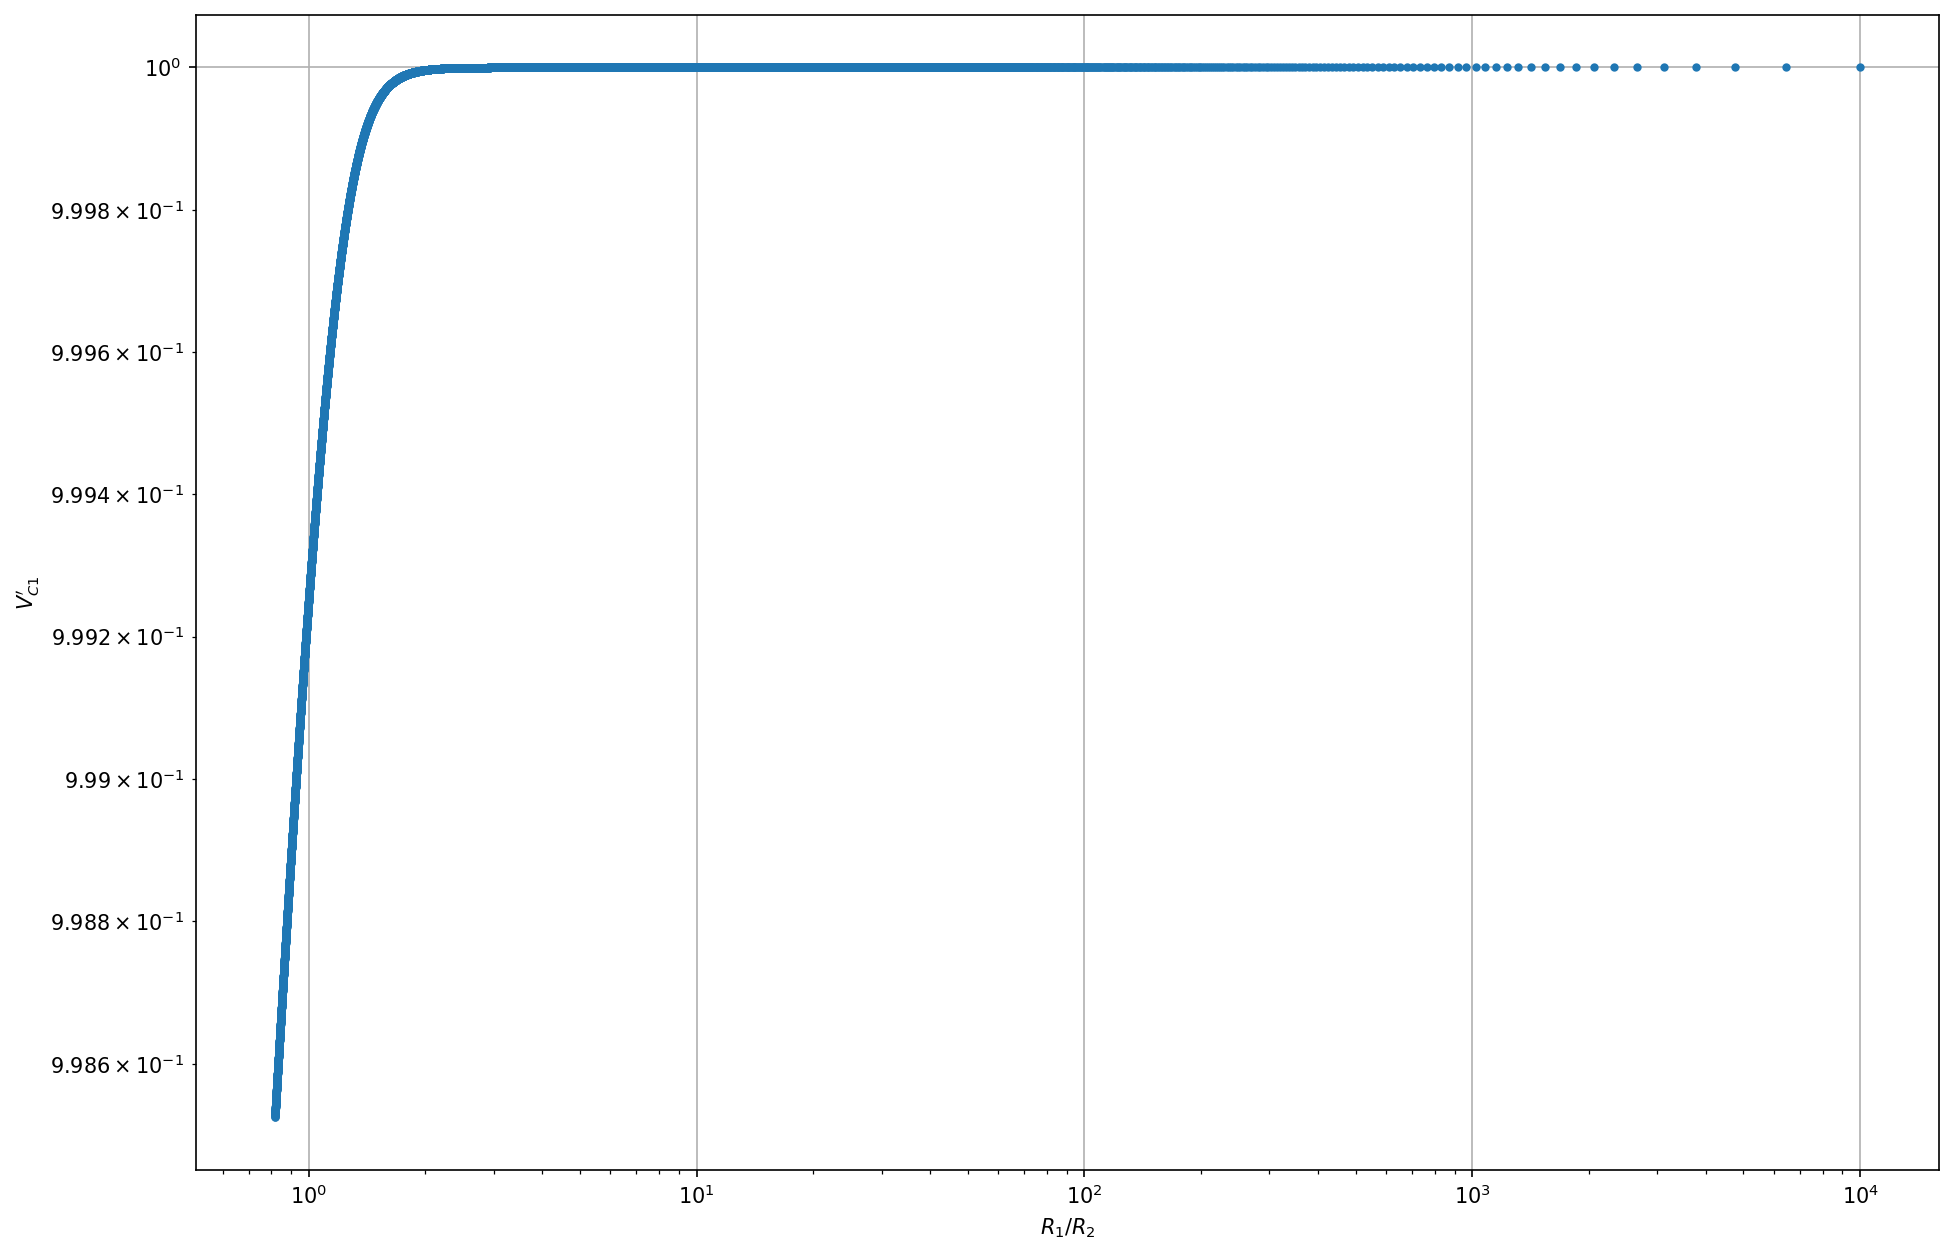

In [162]:
fig = plt.figure(figsize=(15,10), dpi=150)
ax0 = fig.add_subplot(1, 1, 1, xlabel='$R_1/R_2$', ylabel='$V_{C1}\'$', title='')
ax0.grid()
ax0.loglog(r1_forward[0:]/(10000-r1_forward[0:]), root_forward_r1r2[:,0], '.')

In [163]:
h=0
root_backward_r1r2 = np.empty((N+h,6))
r1_backward = np.linspace(1, r1_forward[0], N+h)

In [164]:
root_backward_r1r2[-1] = root(F, x0, args=(r1_forward[h], 10000 - r1_forward[h], r3_0), jac=jac, method='hybr', options={"xtol":0.000001, "eps":0.00001}).x
root(F, x0, args=(r1_forward[h], 10000 - r1_forward[h], r3_0), jac=jac, method='hybr', options={"xtol":0.000001, "eps":0.00001})
for i in range(N-1+h):
    root_backward_r1r2[-(i+2)] = root(F, root_backward_r1r2[-(i+1)], args=(r1_backward[-(i+2)], 10000 - r1_backward[-(i+2)], r3_0), jac=jac, method='hybr', options={"xtol":0.000001, "eps":0.00001}).x

 message: The solution converged.
 success: True
  status: 1
     fun: [ 5.272e-03  5.272e-05  1.732e-03  2.396e-06 -2.666e-14
            2.082e-13]
       x: [ 9.985e-01  9.985e-01  6.395e-02 -4.516e-01  1.333e-20
            1.229e-04]
  method: hybr
    nfev: 80
    njev: 3
    fjac: [[-2.397e-03 -2.397e-05 ...  9.999e-01 -5.000e-03]
           [-9.516e-01 -5.111e-02 ...  4.573e-04 -5.150e-03]
           ...
           [-2.090e-04 -4.562e-02 ...  9.701e-05  2.015e-02]
           [ 1.037e-02  1.025e-02 ... -4.813e-03 -9.995e-01]]
       r: [ 1.000e+06 -1.001e+06 ... -2.517e+04  1.249e+06]
     qtf: [-2.609e-04 -3.842e-02 -2.893e-02 -6.728e-03 -1.549e-05
            7.686e-04]

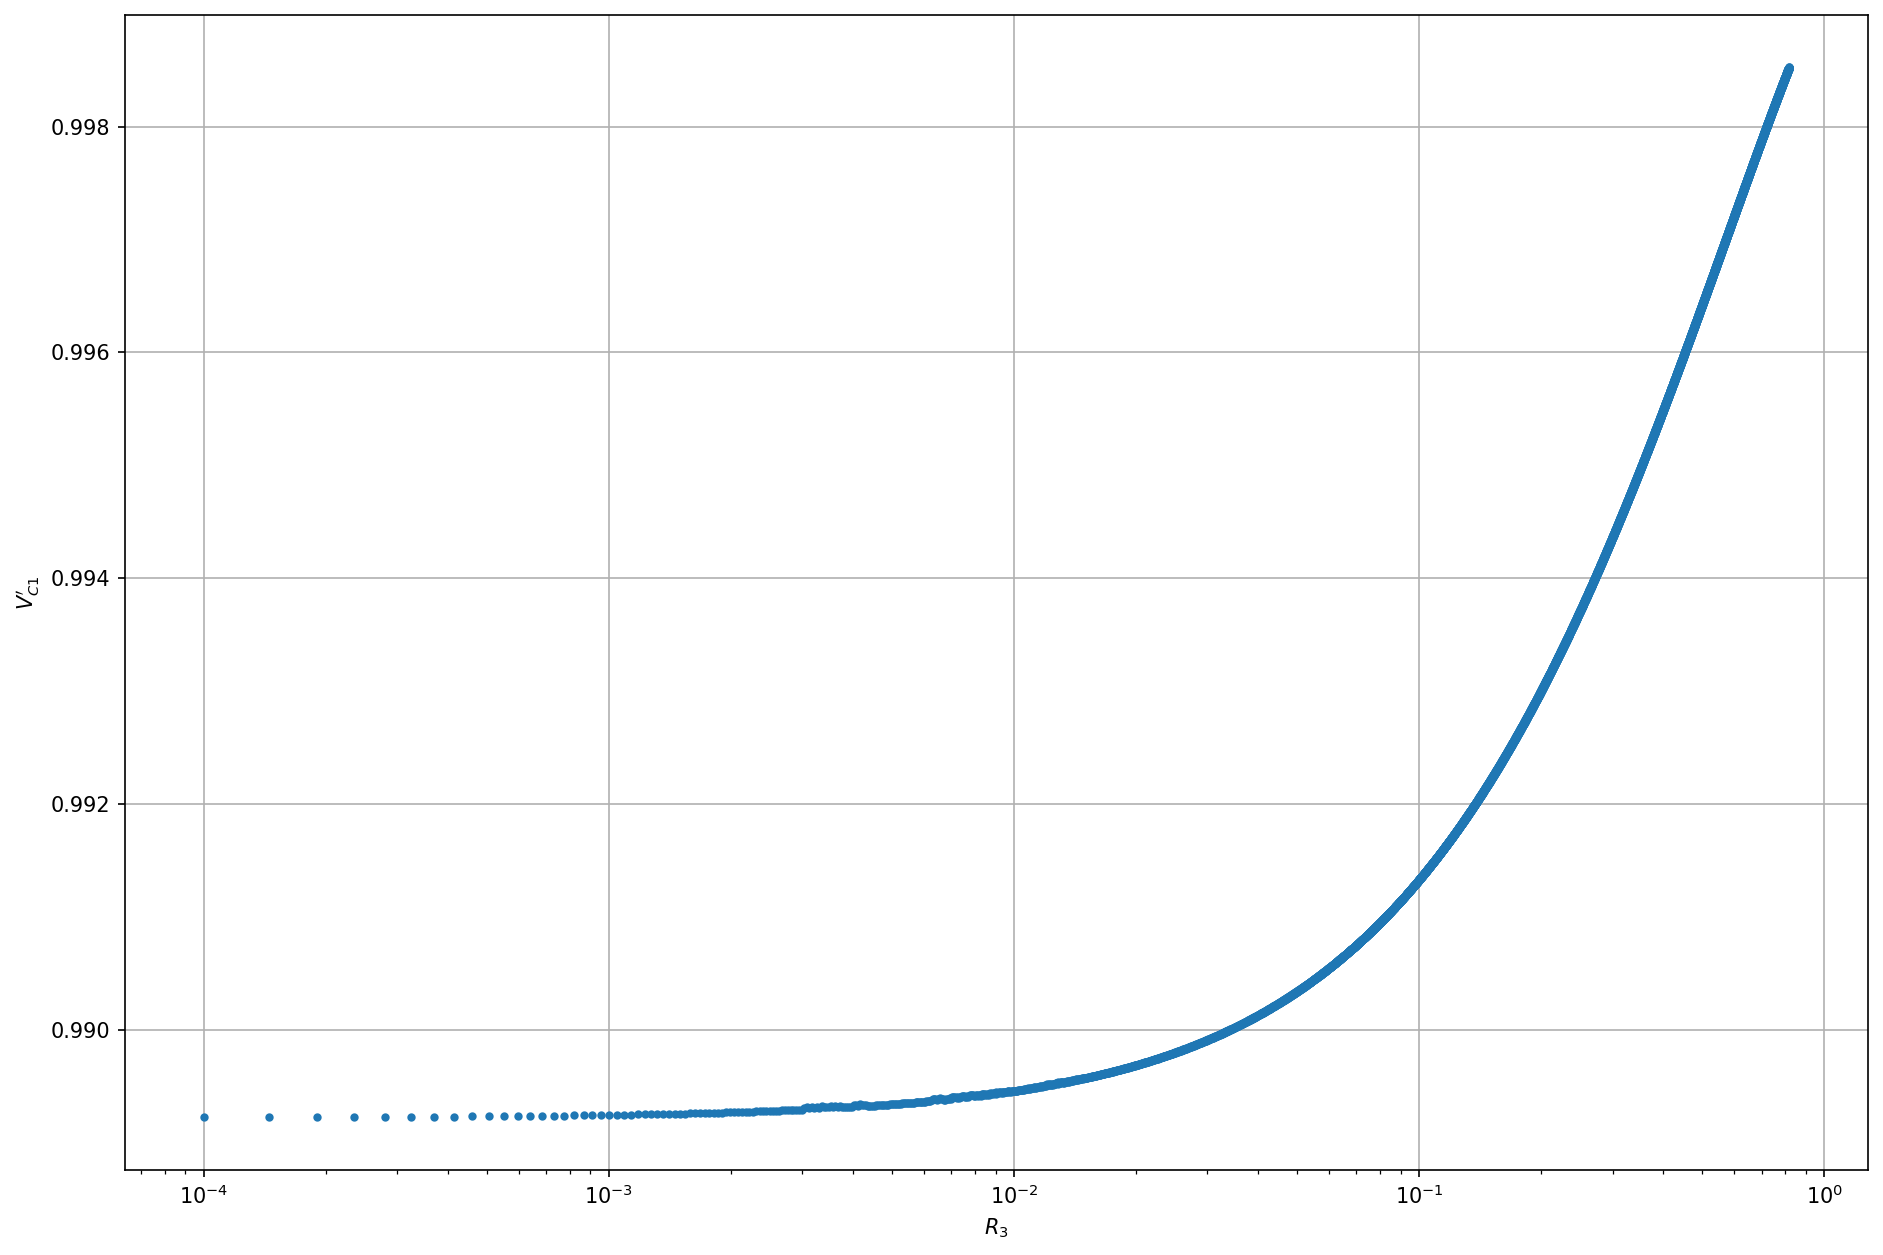

In [165]:
fig = plt.figure(figsize=(15,10), dpi=150)
ax0 = fig.add_subplot(1, 1, 1, xlabel='$R_3$', ylabel='$V_{C1}\'$', title='')
ax0.grid()
ax0.semilogx(r1_backward[0:]/(10000-r1_backward[0:]), root_backward_r1r2[:,0], '.')

In [166]:
r1r2_ = np.append(r1_backward/(10000-r1_backward), r1_forward/(10000-r1_forward))
roots_r1r2 = np.append(root_backward_r1r2, root_forward_r1r2, axis=0)

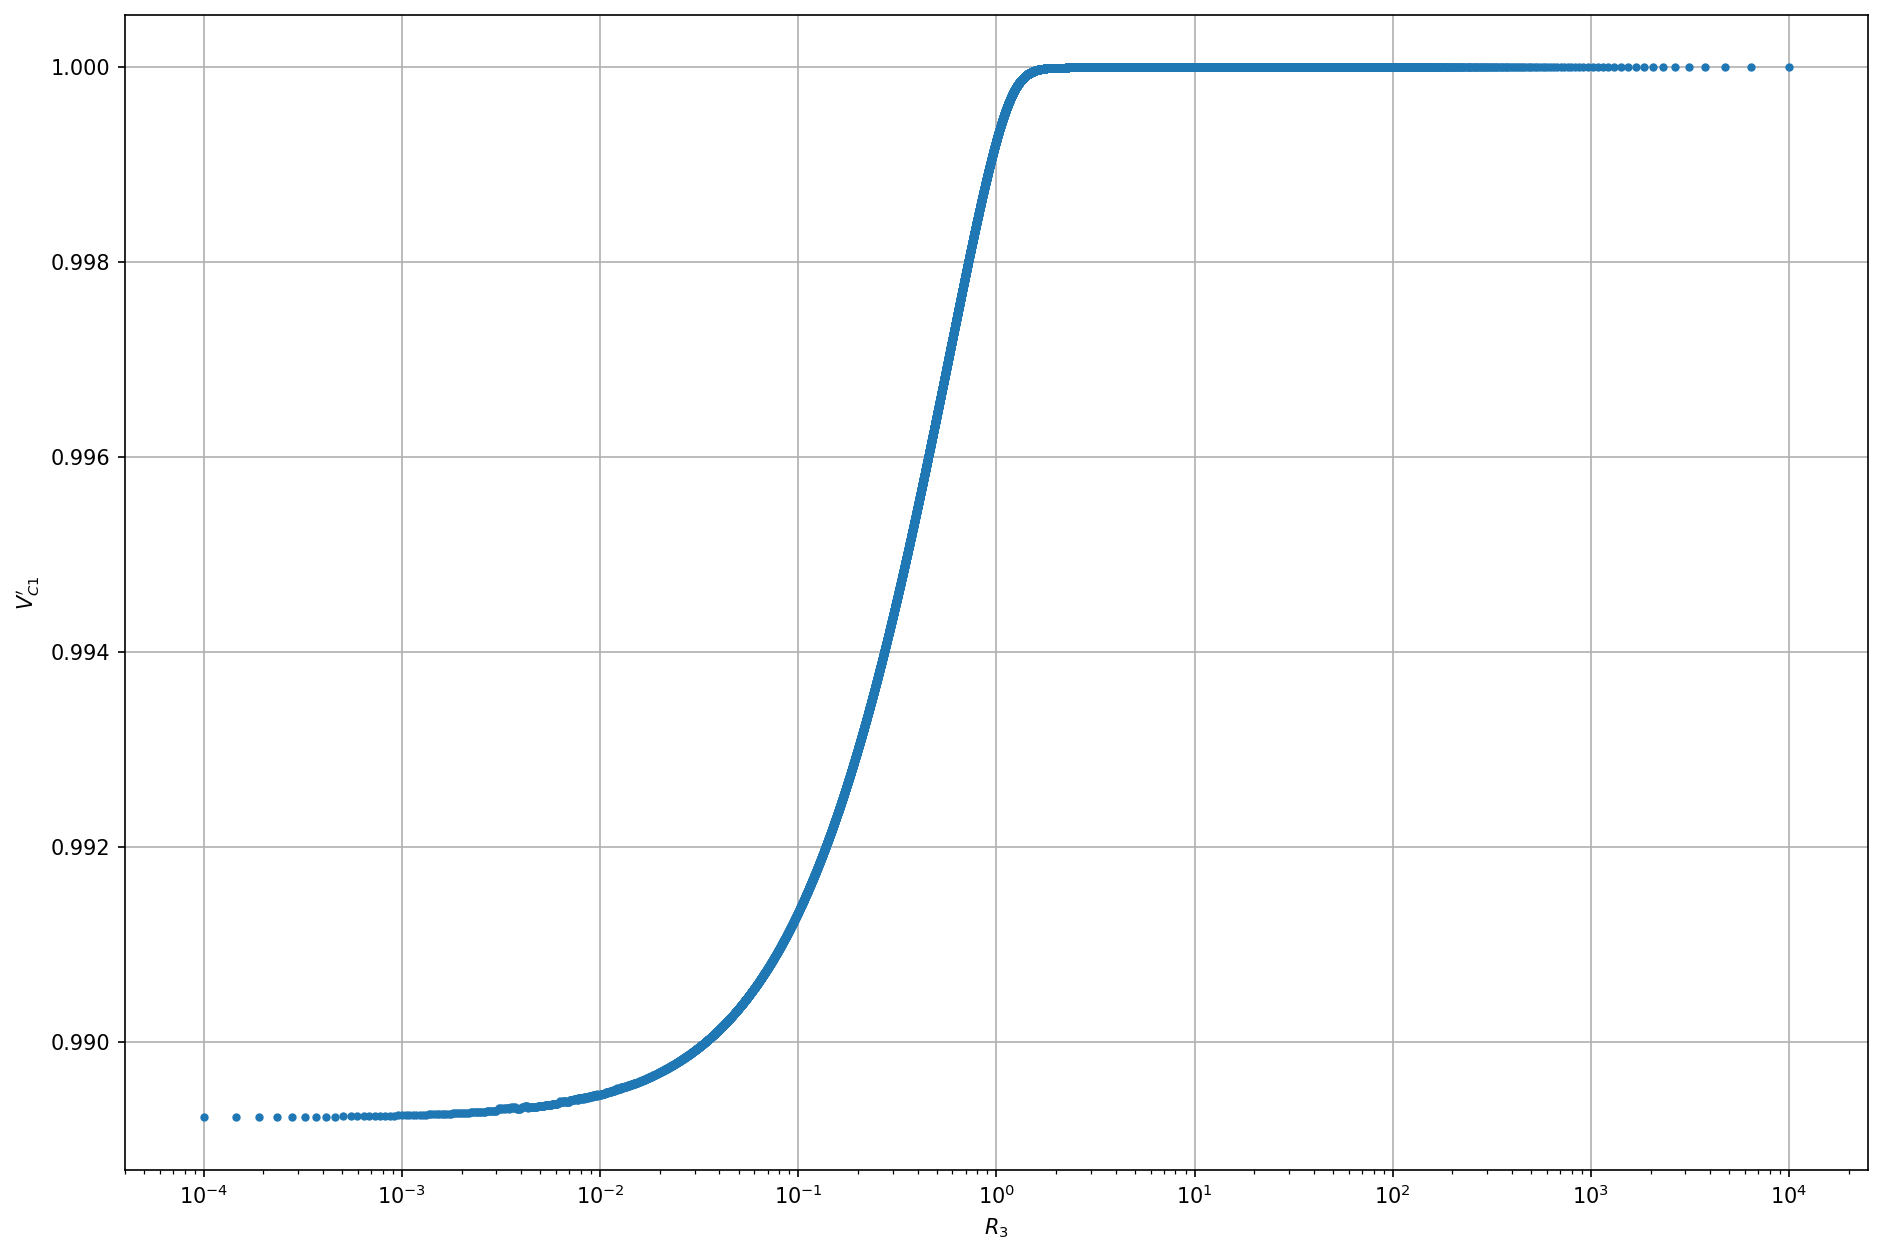

In [167]:
fig = plt.figure(figsize=(15,10), dpi=150)
ax0 = fig.add_subplot(1, 1, 1, xlabel='$R_3$', ylabel='$V_{C1}\'$', title='')
ax0.grid()
ax0.semilogx(r1r2_, roots_r1r2[:,1], '.')

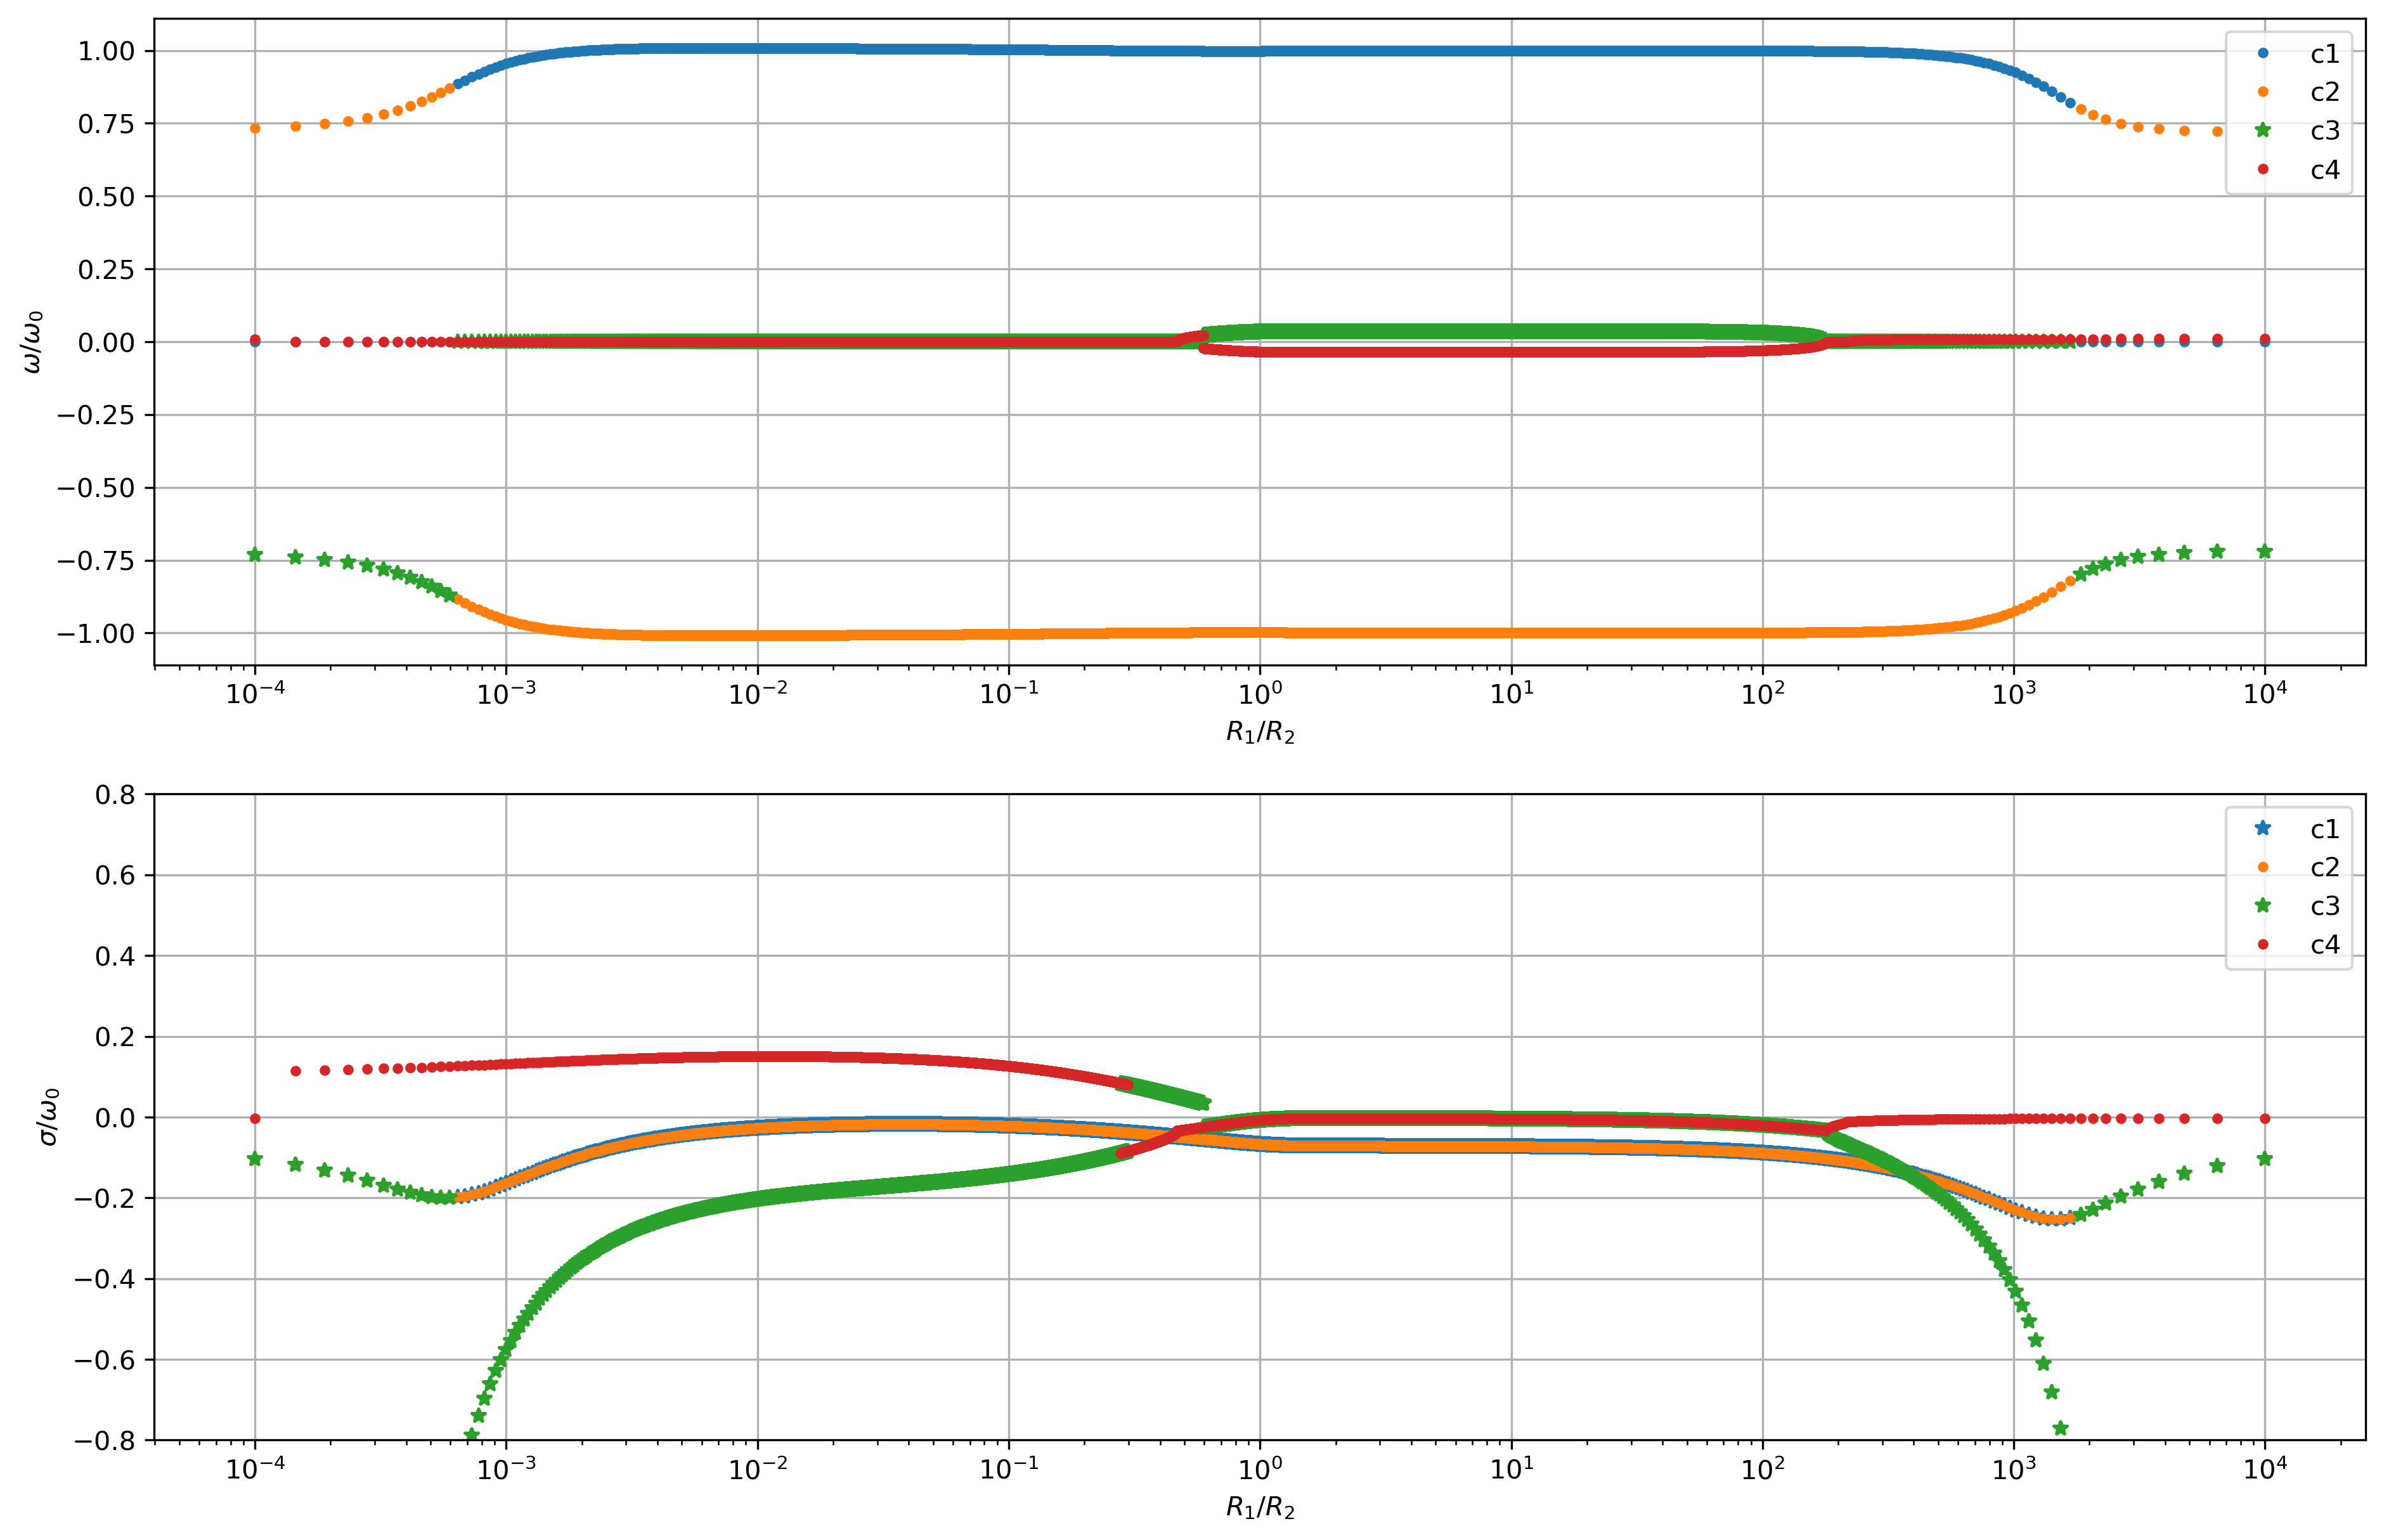

In [168]:
r1_ = np.append(r1_backward, r1_forward)
r2_ = np.append(10000-r1_backward, 10000-r1_forward)
PlotSpectra(1, r1_, r2_, r3_0, roots_r1r2)

## R1/R2, r3=100

In [169]:
N = 10000
d = 4500.0
r1_0, r2_0 = d, 1e4-d

x0 = [0.9032996243204605,
      1.0597264109247453,
      0.4180170045019157,
      -0.05715287030868942,
      0.021509967006432887,
      0.004539551658565542]

r3_0 = 100.0

In [170]:
root_forward_r1r2 = np.empty((N,6))
r1_forward = np.linspace(r1_0, 9999, N)

In [171]:
root_forward_r1r2[0] = root(F, x0, args=(r1_0, r2_0, r3_0), jac=jac, method='hybr', options={"xtol":0.000001, "factor":10}).x

for i in range(N-1):
    root_forward_r1r2[i+1] = root(F, root_forward_r1r2[i], args=(r1_forward[i+1], 10000 - r1_forward[i+1], r3_0), jac=jac, method='hybr', options={"xtol":0.000001, "factor":1}).x

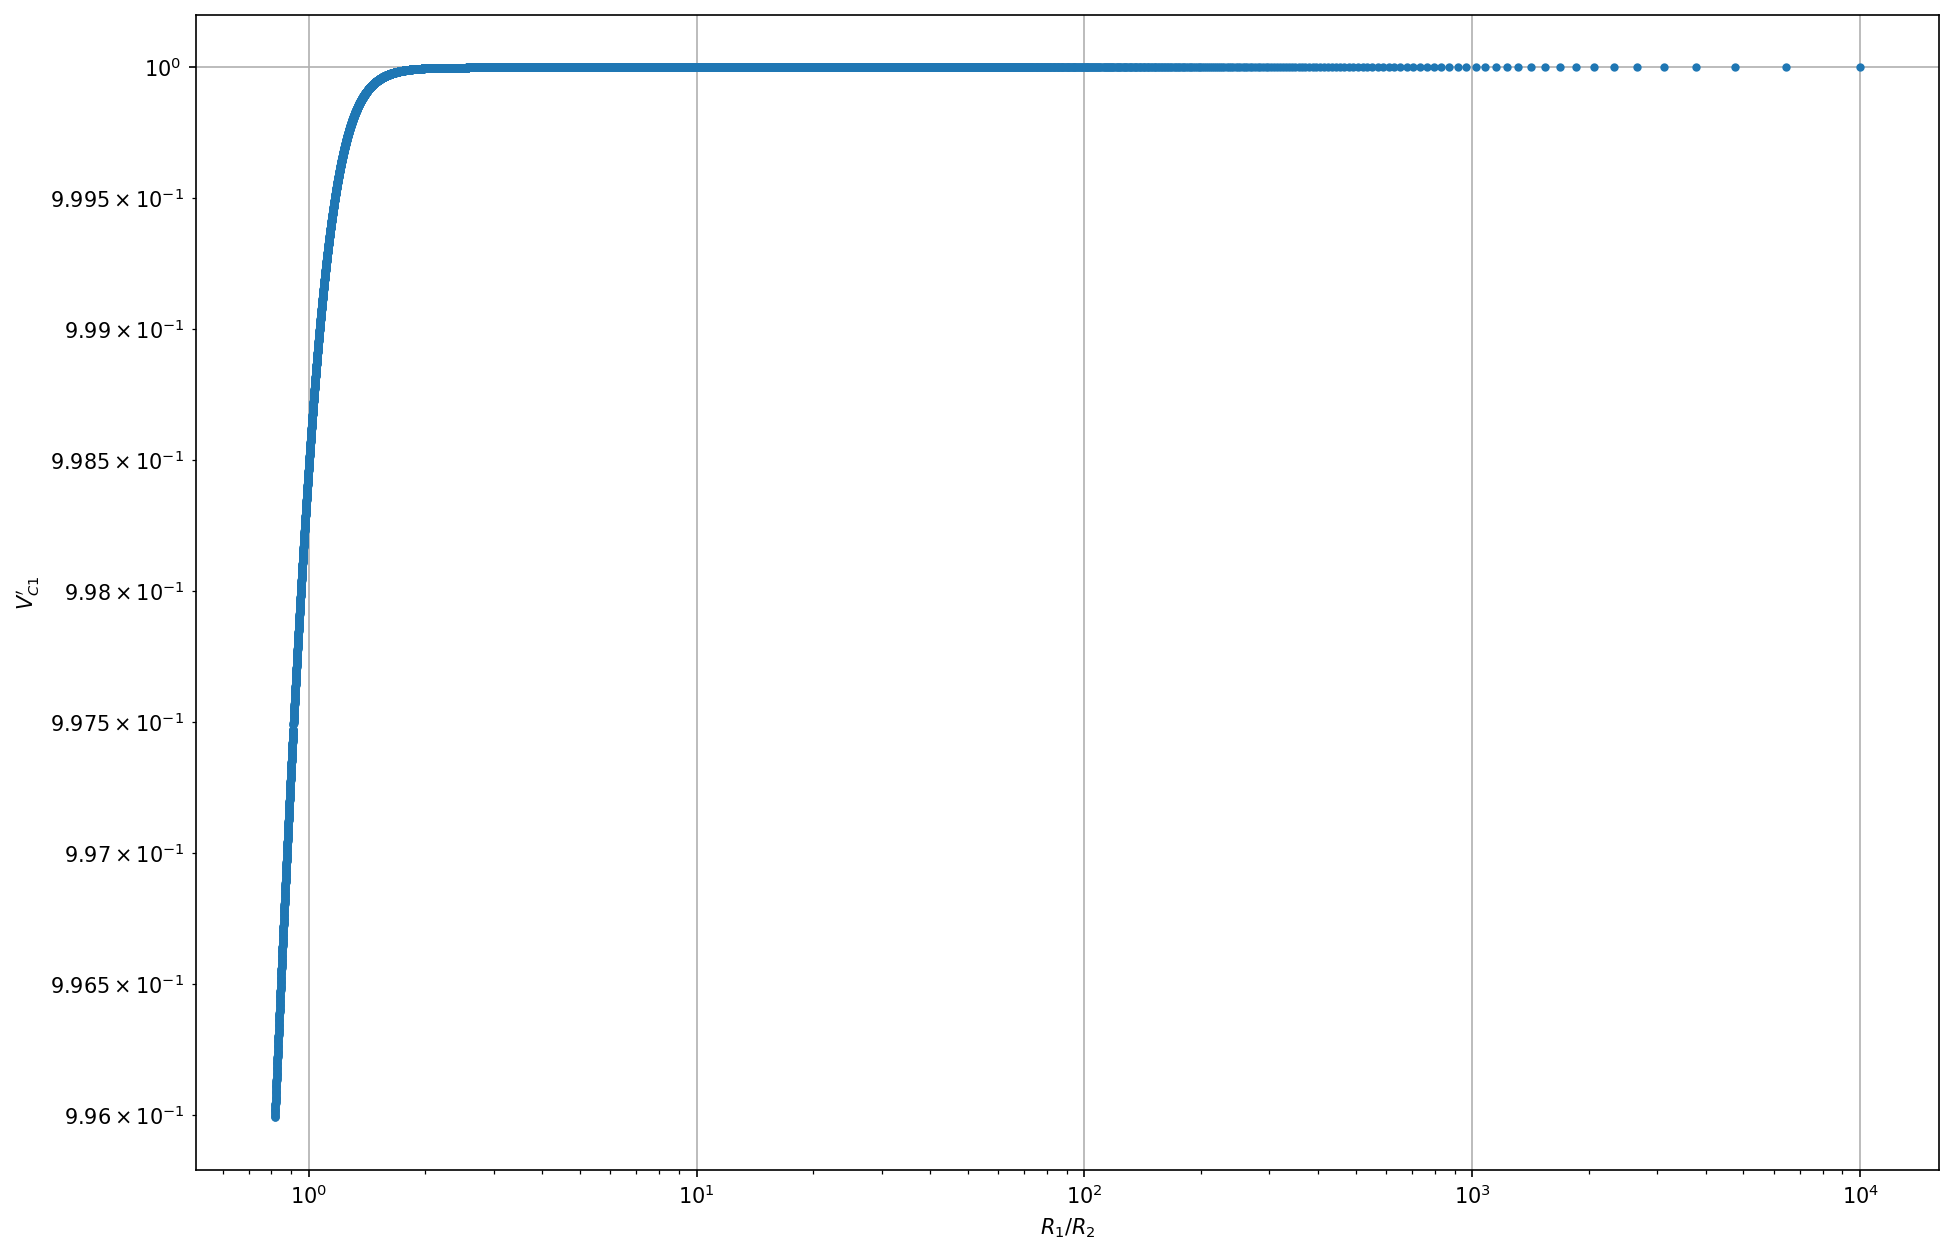

In [172]:
fig = plt.figure(figsize=(15,10), dpi=150)
ax0 = fig.add_subplot(1, 1, 1, xlabel='$R_1/R_2$', ylabel='$V_{C1}\'$', title='')
ax0.grid()
ax0.loglog(r1_forward[0:]/(10000-r1_forward[0:]), root_forward_r1r2[:,0], '.')

In [173]:
h=0
root_backward_r1r2 = np.empty((N+h,6))
r1_backward = np.linspace(1, r1_forward[0], N+h)

In [174]:
root_backward_r1r2[-1] = root(F, x0, args=(r1_forward[h], 10000 - r1_forward[h], r3_0), jac=jac, method='hybr', options={"xtol":0.000001, "eps":0.00001}).x
root(F, x0, args=(r1_forward[h], 10000 - r1_forward[h], r3_0), jac=jac, method='hybr', options={"xtol":0.000001, "eps":0.00001})
for i in range(N-1+h):
    root_backward_r1r2[-(i+2)] = root(F, root_backward_r1r2[-(i+1)], args=(r1_backward[-(i+2)], 10000 - r1_backward[-(i+2)], r3_0), jac=jac, method='hybr', options={"xtol":0.0000001, "eps":0.00001}).x

 message: The solution converged.
 success: True
  status: 1
     fun: [ 3.418e-05  3.418e-07 -1.571e-05  1.553e-08 -5.516e-14
           -1.691e-13]
       x: [ 9.960e-01  9.960e-01  3.374e-02 -4.543e-01  2.758e-20
            3.340e-04]
  method: hybr
    nfev: 24
    njev: 4
    fjac: [[-1.212e-03 -1.212e-05 ...  1.000e+00 -5.000e-03]
           [ 9.082e-01  3.816e-02 ...  1.351e-03  3.592e-03]
           ...
           [-6.932e-02  8.675e-01 ... -2.465e-03 -4.867e-01]
           [ 3.364e-03  3.366e-03 ...  1.196e-04  2.362e-02]]
       r: [ 1.000e+06 -9.981e+05 ... -6.921e+06  3.358e+05]
     qtf: [-1.837e-04  1.377e-01 -6.065e-04 -2.359e-03 -3.224e-03
            1.565e-04]

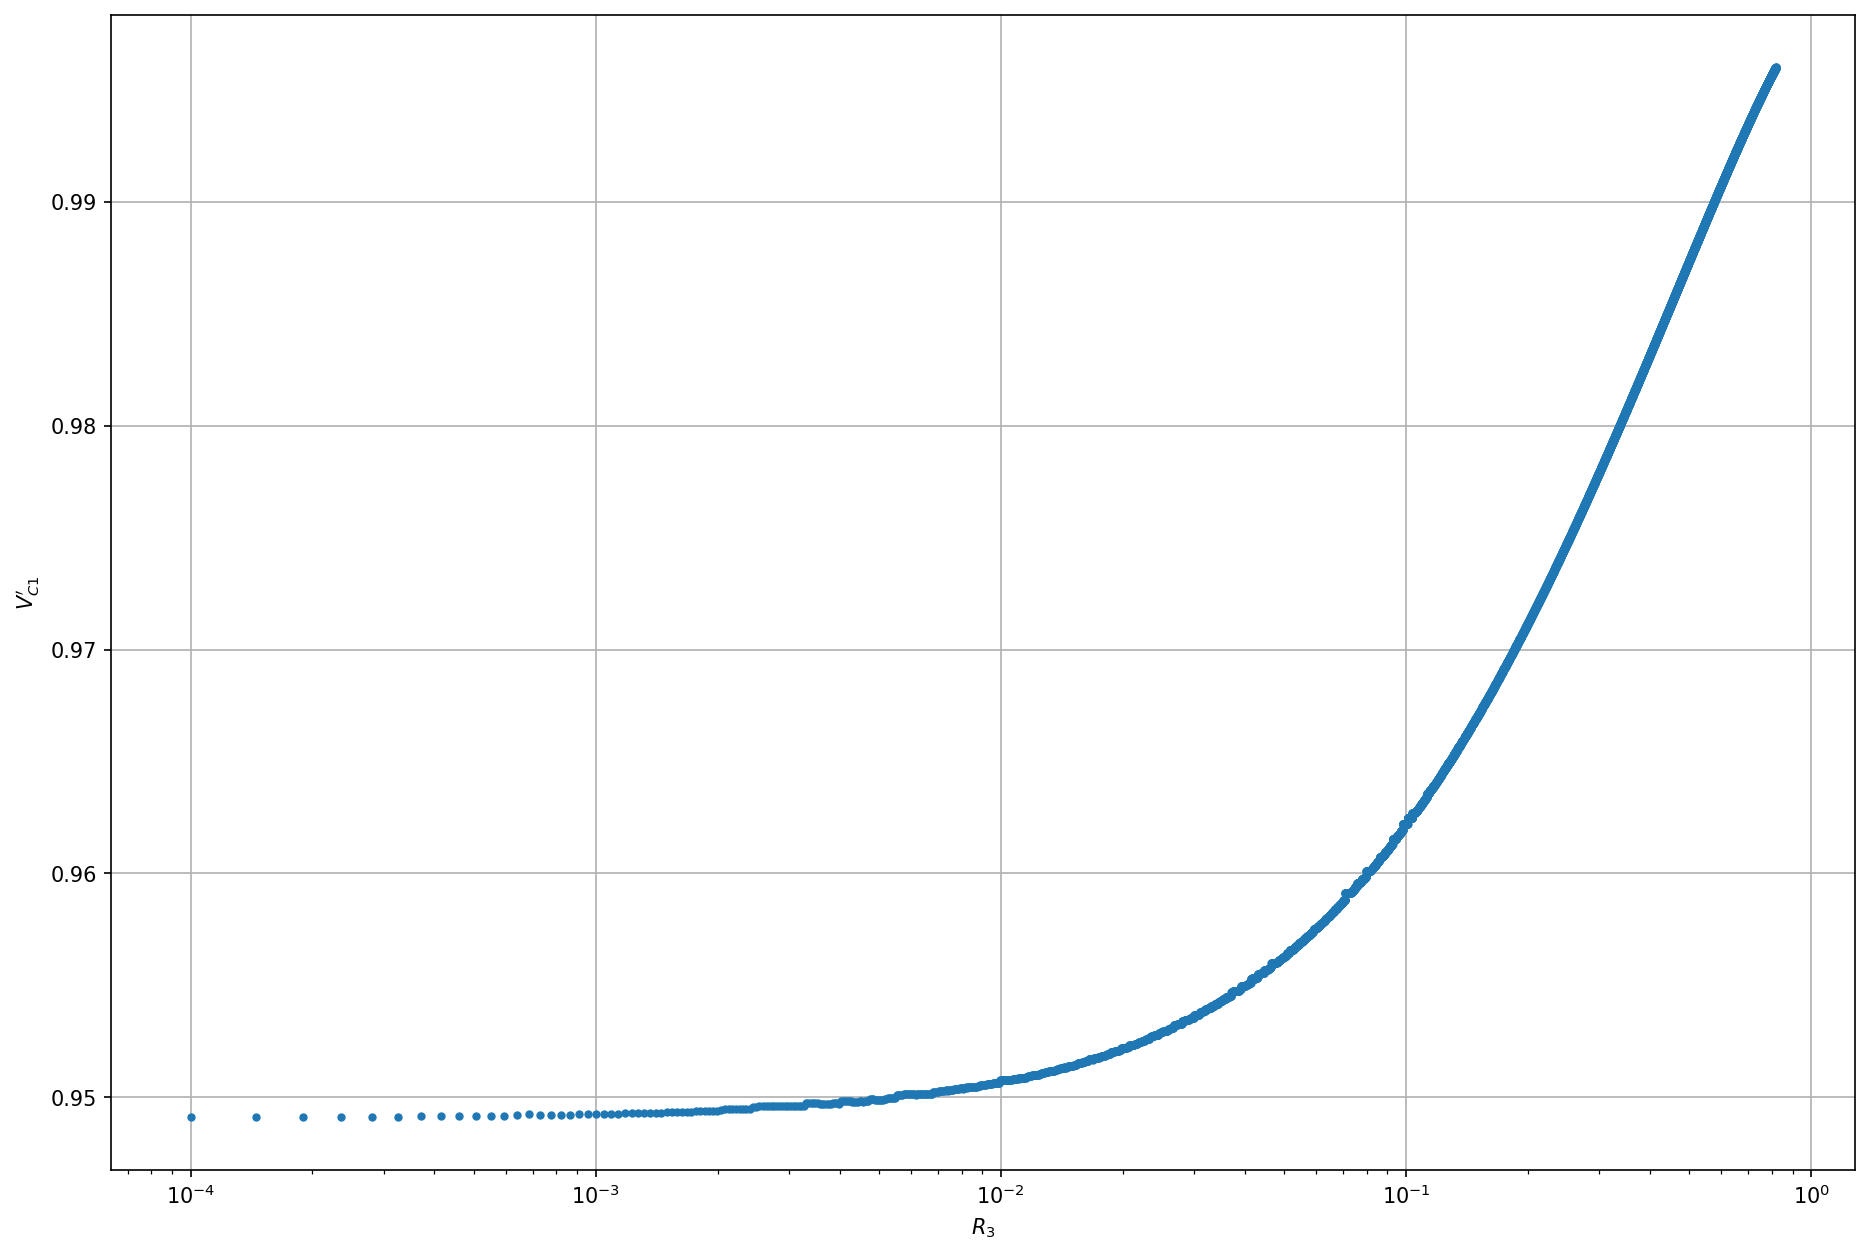

In [175]:
fig = plt.figure(figsize=(15,10), dpi=150)
ax0 = fig.add_subplot(1, 1, 1, xlabel='$R_3$', ylabel='$V_{C1}\'$', title='')
ax0.grid()
ax0.semilogx(r1_backward[0:]/(10000-r1_backward[0:]), root_backward_r1r2[:,0], '.')

In [176]:
r1r2_ = np.append(r1_backward/(10000-r1_backward), r1_forward/(10000-r1_forward))
roots_r1r2 = np.append(root_backward_r1r2, root_forward_r1r2, axis=0)

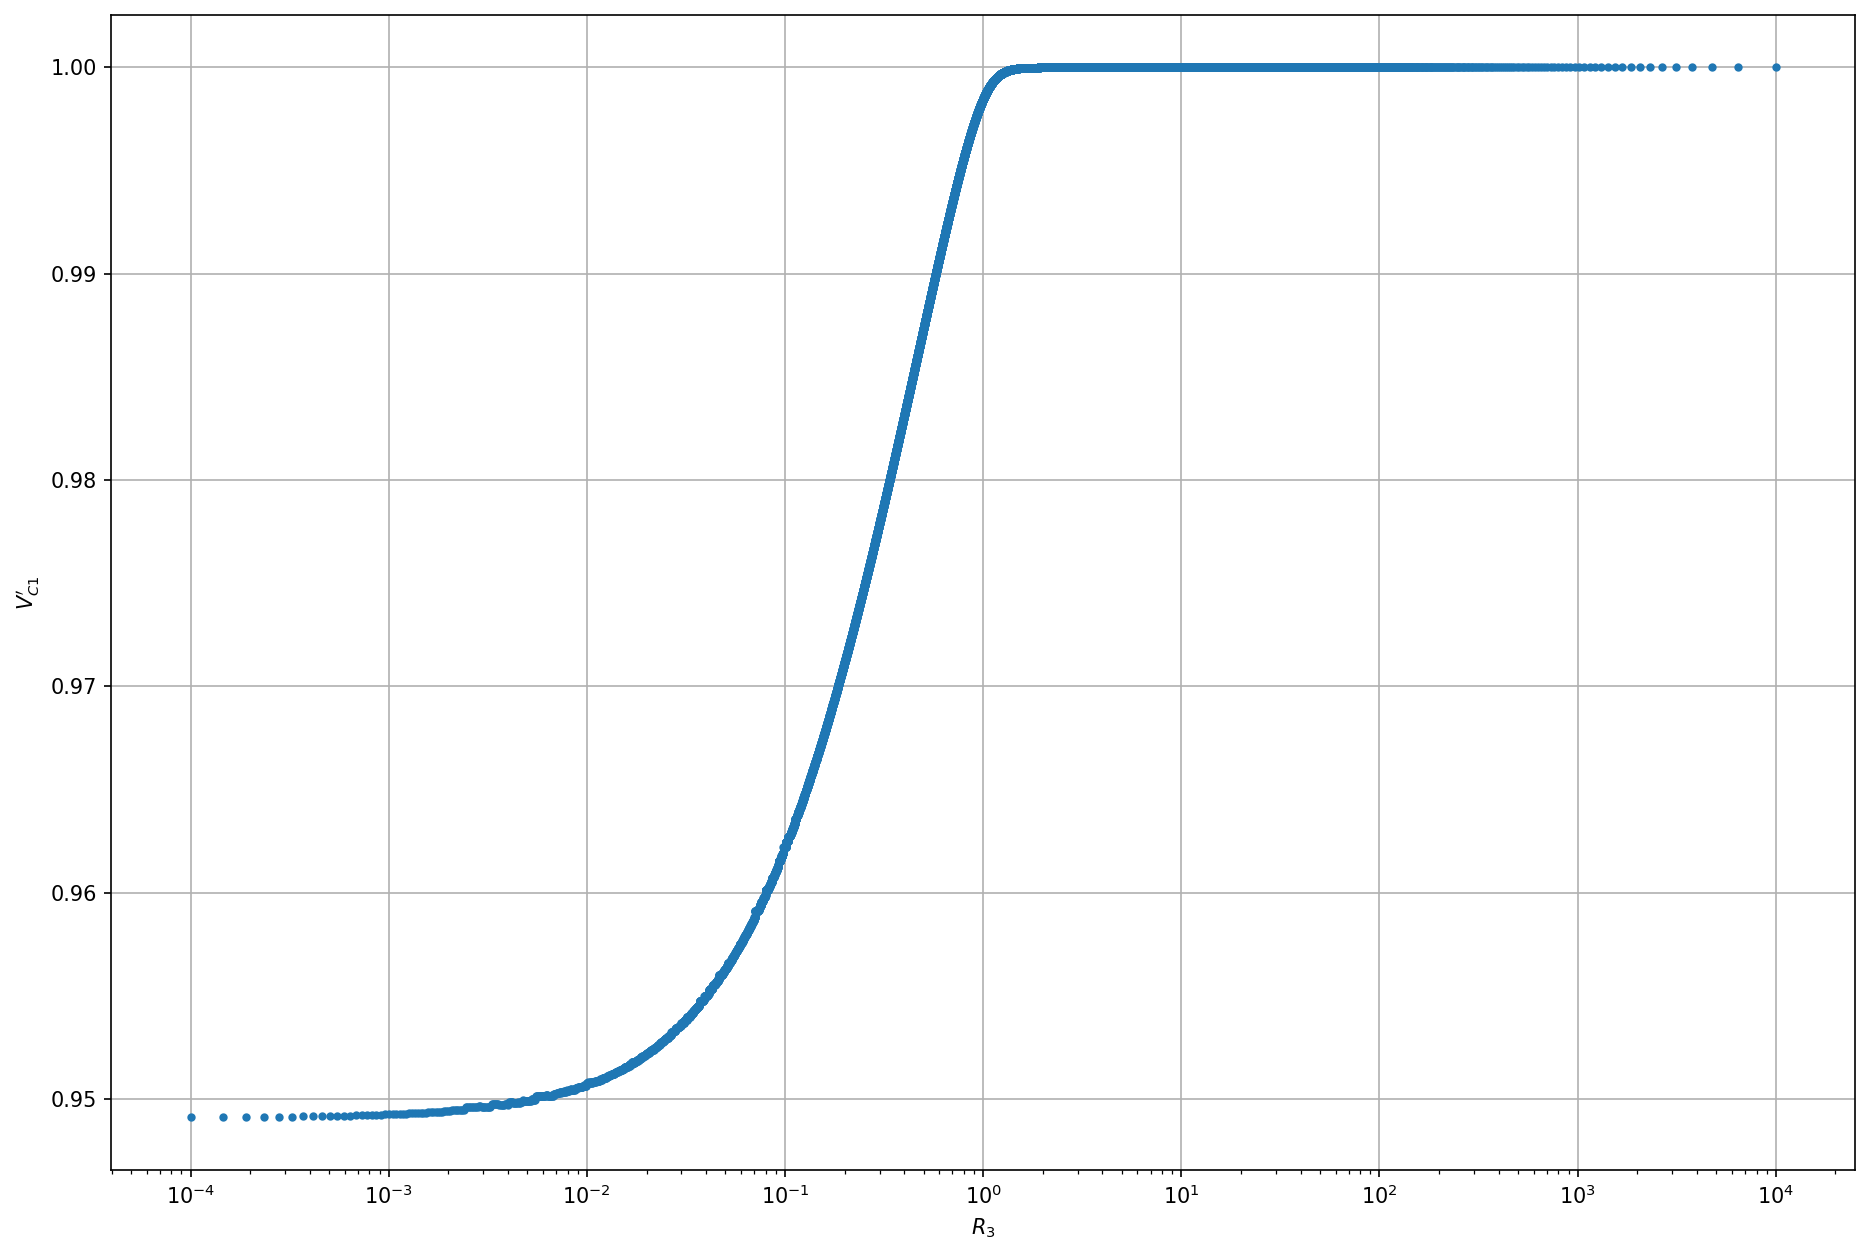

In [177]:
fig = plt.figure(figsize=(15,10), dpi=150)
ax0 = fig.add_subplot(1, 1, 1, xlabel='$R_3$', ylabel='$V_{C1}\'$', title='')
ax0.grid()
ax0.semilogx(r1r2_, roots_r1r2[:,1], '.')

\
\
The third graph below is a slice over the domain of the parameterized variable and the vertical axis is the sum of the imaginary components. I had tried to experimentally condition a circuit to operate at the point just on the x-axis as I thought this might mean that the oscillations would diminish. I did not get that result.

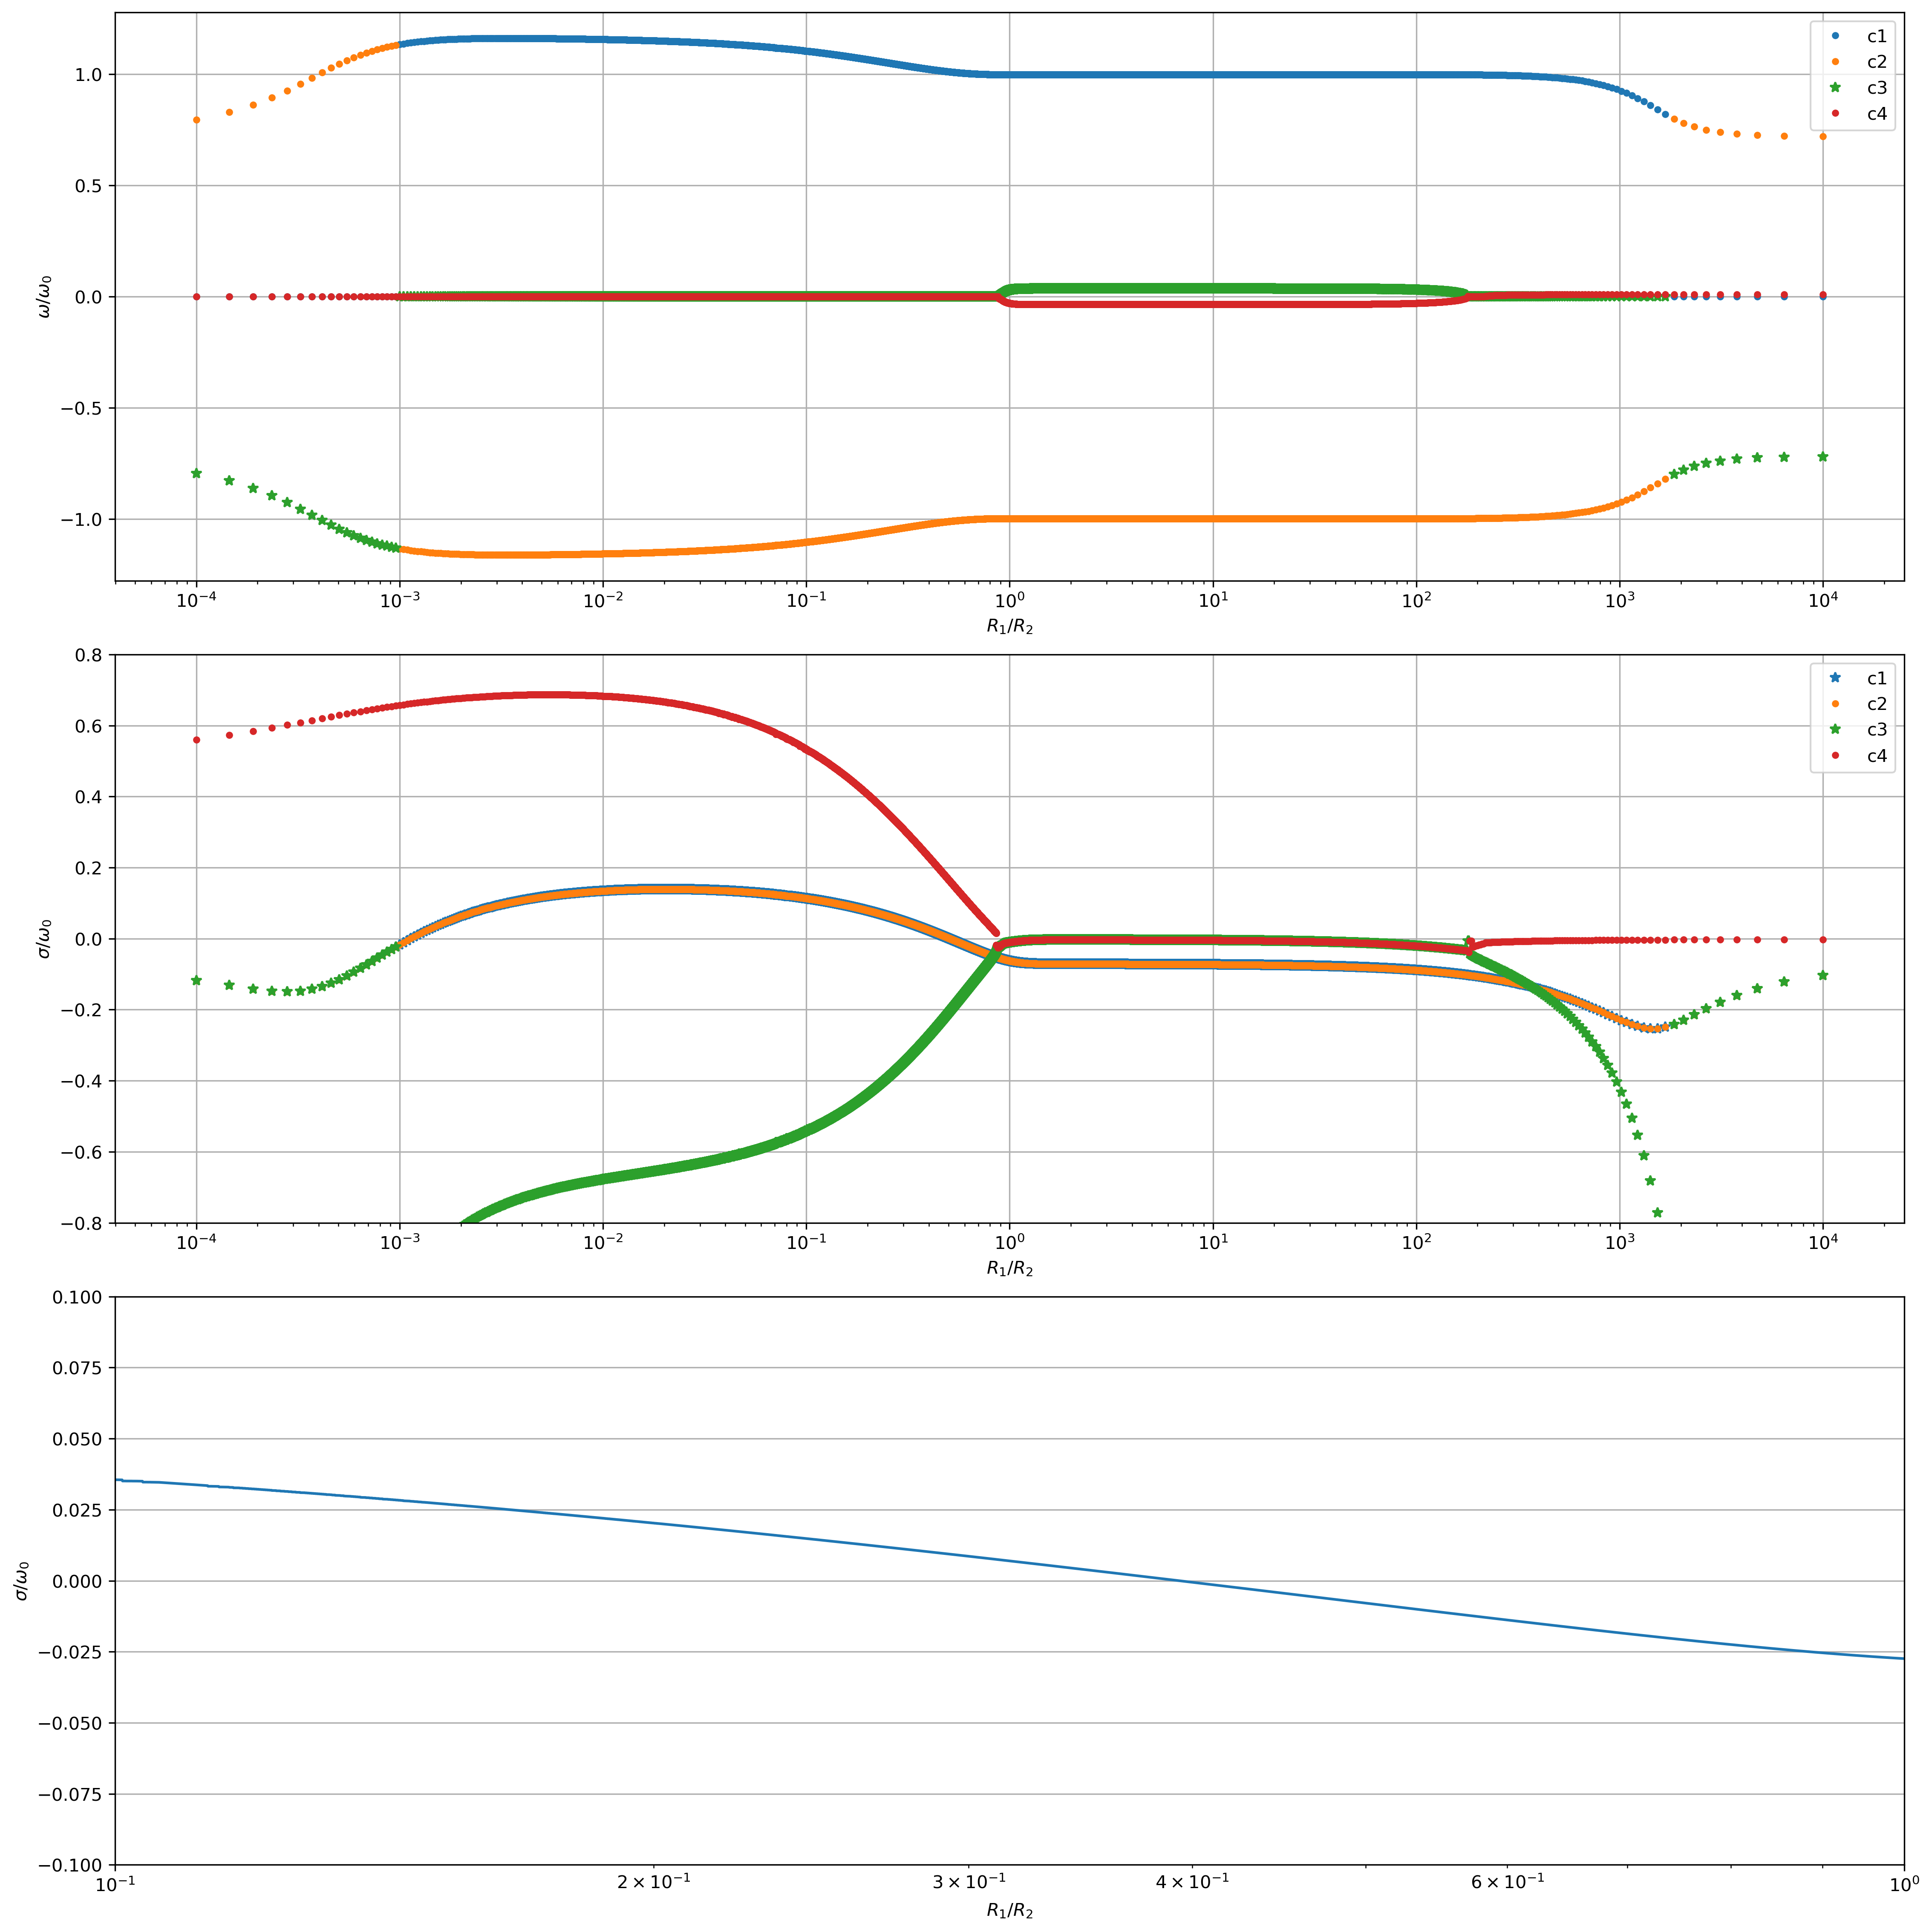

In [197]:
r1_ = np.append(r1_backward, r1_forward)
r2_ = np.append(10000-r1_backward, 10000-r1_forward)
PlotSpectra(1, r1_, r2_, r3_0, roots_r1r2)

Here I was trying out some simulated values.

r3 = 100, r1 = 2500
<img src="../Pics/TimeSeries_r3-100_r1-2500.png" />